# GraphRAG

This cookbook shows how to implement GraphRAG using LangChain and Neo4j! It includes using Crawl4AI to get articles and adapts Neo4j codes from the [LangChain Neo4j Article](https://blog.langchain.dev/enhancing-rag-based-applications-accuracy-by-constructing-and-leveraging-knowledge-graphs/)

In [1]:
%load_ext autoreload 
%autoreload 2

### ⚙️ Enabling Async Support in Jupyter Notebooks

Jupyter Notebooks already run inside an event loop, which conflicts with `asyncio.run()` or other async constructs that try to create a new loop. This leads to the classic error:

`RuntimeError: This event loop is already running`

🔧 What `nest_asyncio` does:
The nest_asyncio library patches the running event loop so you can safely run and await nested asynchronous code inside a Jupyter cell — like `await`, `asyncio.gather()`, or any `async def` coroutine.

In [2]:
import nest_asyncio
nest_asyncio.apply()

# Get data!
Using our favorite Crawl4AI!

In [15]:
urls = [
    "https://www.forbes.com/councils/forbesbusinesscouncil/2025/03/19/reconsidering-the-mba-is-it-still-worth-it/",
    "https://online.hbs.edu/blog/post/roi-of-an-mba",
    "https://plannerbee.co/learn-personal-finance/mba-singapore-worth/",
    "https://www.coursera.org/articles/is-an-mba-worth-it",
    "https://www.singsaver.com.sg/blog/is-an-mba-worth-it"
]

In [4]:
from crawl4ai import AsyncWebCrawler, CrawlerRunConfig

Run this cell if you need to setup playwright dependencies.

In [ ]:
# !playwright install

125.8 MiB [                    ] 0% 0.0s125.8 MiB [                    ] 0% 23.4s125.8 MiB [                    ] 0% 13.6s125.8 MiB [                    ] 0% 7.6s125.8 MiB [                    ] 1% 5.5s125.8 MiB [                    ] 1% 5.7s125.8 MiB [                    ] 1% 10.5s125.8 MiB [                    ] 2% 9.3s125.8 MiB [=                   ] 3% 5.7s125.8 MiB [=                   ] 4% 5.5s125.8 MiB [=                   ] 5% 4.6s125.8 MiB [=                   ] 6% 4.2s125.8 MiB [=                   ] 7% 3.7s125.8 MiB [==                  ] 8% 3.5s125.8 MiB [==                  ] 8% 3.3s125.8 MiB [==                  ] 10% 3.0s125.8 MiB [==                  ] 11% 2.7s125.8 MiB [==                  ] 12% 2.7s125.8 MiB [===                 ] 12% 2.8s125.8 MiB [===                 ] 13% 2.8s125.8 MiB [===                 ] 13% 3.4s125.8 MiB [===                 ] 13% 3.5s125.8 MiB [===                 ] 15% 3.1s125.8 MiB [===                 ] 17% 2.8s125.8 MiB [====             

## 🕸️ Asynchronous Web Scraping and Text Chunking for Forbes & HBS Blogs

This cell defines and runs an async web crawling pipeline that extracts text from structured blog pages (like Forbes or Harvard Business School), then splits the content into LangChain `Document` objects for downstream use.

🔍 What this code does:
1. Define extract_forbes_hbs_blog(url)
- Uses `JsonXPathExtractionStrategy` to target specific tags.
- Crawls the web page asynchronously using `AsyncWebCrawler`.
- Extracts raw text into a sequence of paragraphs/headings.
- Raises a RuntimeError if the crawl fails.

2. Define crawl_websites(urls)
- Accepts a list of URLs and runs multiple extractions concurrently using `asyncio.gather`.
- Joins each article's text into one string and splits it using `RecursiveCharacterTextSplitter` for chunked processing.
- Each chunk is wrapped in a `Document` object with metadata (source URL).

3. Run the Crawl: Executes the crawl and parsing pipeline asynchronously.

> ⚙️ What is asyncio and why is it used here?
> `asyncio` is Python’s built-in library for asynchronous programming. It enables your code to perform other tasks while waiting (e.g., for a web request to return), which is especially helpful when:
> - Making network requests (like web crawling or API calls).
> - Performing I/O-bound operations that would otherwise block the main thread.
> - Needing to scale to many concurrent tasks without creating multiple threads or processes.

In this code:
- `async` def declares asynchronous functions.
- `await` pauses execution until a coroutine completes (like `crawler.arun(...)`).
- `asyncio.gather(...)` runs all crawling tasks in parallel, making it far faster than crawling sequentially.

This makes the crawler much faster and more efficient, especially when dealing with many article URLs

In [ ]:
import json
import time
import asyncio
from crawl4ai.extraction_strategy import JsonXPathExtractionStrategy
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents.base import Document

text_splitter = RecursiveCharacterTextSplitter()

async def extract_forbes_hbs_blog(url: str) -> list[str]:
    """Extracts textual content from Forbes or Harvard Business School (HBS) blog articles using a predefined HTML tag schema.

    The function leverages a JSON XPath extraction strategy to extract the text content from specific tags 
    (`<title>`, `<h2>`, `<h3>`, `<p>`) within the given URL. This is designed specifically for structured articles 
    like those from Forbes or HBS.

    Args:
        url (str): The URL of the article to extract content from.

    Returns:
        list[str]: A list of strings, each representing text content from the matched HTML tags in sequence.

    Raises:
        RuntimeError: If the crawler fails to extract content from the provided URL.
    """
    
    schema = {
        "name": "Title_H2_P_Sequence",
        "baseSelector": "//title | //h2 | //h3| //p",
        "fields": [
            {
                "name": "text",
                "selector": ".",
                "type": "text"
            }
        ]
    }

    strategy = JsonXPathExtractionStrategy(schema, verbose=True)
    config = CrawlerRunConfig(
        extraction_strategy=strategy
    )

    async with AsyncWebCrawler() as crawler:
        result = await crawler.arun(url, config=config)

    if not result.success:
        raise RuntimeError(f"Crawl failed: {result.error_message}")

    items = json.loads(result.extracted_content)
    return [item["text"] for item in items]

async def crawl_websites(urls: list[str]) -> list[Document]:
    """
    Crawls multiple article URLs and extracts their content into structured `Document` objects.

    This function asynchronously processes a list of Forbes or HBS article URLs by calling 
    `extract_forbes_hbs_blog()` for each. The extracted text sequences are then grouped into 
    documents with associated metadata (e.g., source URL), using a text splitter.

    Args:
        urls (list[str]): A list of article URLs to be crawled and processed.

    Returns:
        list[Document]: A list of LangChain `Document` objects
        from a single article. Each `Document` contains chunks of the article text along with source metadata.
    """
    all_docs_list = []
    tasks = [extract_forbes_hbs_blog(url) for url in urls]
    results_sequences = await asyncio.gather(*tasks, return_exceptions=True)
    
    for seq, url in zip(results_sequences, urls):
        article = "\n\n".join(seq)
        docs = text_splitter.create_documents(
            [article], metadatas=[{"source": url}]
        )
        all_docs_list.extend(docs)
    
    return all_docs_list        

results = await crawl_websites(urls)

time_start = time.time()
docs = await crawl_websites(urls)
end_time = time.time()
print("Time taken to complete task: {0:0.2f} seconds".format(end_time-time_start))

[INIT].... → Crawl4AI 0.6.2
[INIT].... → Crawl4AI 0.6.2
[INIT].... → Crawl4AI 0.6.2
[INIT].... → Crawl4AI 0.6.2
[INIT].... → Crawl4AI 0.6.2
[FETCH]... ↓ https://online.hbs.edu/blog/post/roi-of-an-mba                                                       | ✓ | ⏱: 0.70s
[SCRAPE].. ◆ https://online.hbs.edu/blog/post/roi-of-an-mba                                                       | ✓ | ⏱: 0.08s
[EXTRACT]. ■ Completed for https://online.hbs.edu/blog/post/roi-of-an-mba... | Time: 0.009128250007051975s
[COMPLETE] ● https://online.hbs.edu/blog/post/roi-of-an-mba                                                       | ✓ | ⏱: 0.81s
[FETCH]... ↓ https://www.singsaver.com.sg/blog/is-an-mba-worth-it                                                 | ✓ | ⏱: 0.94s
[SCRAPE].. ◆ https://www.singsaver.com.sg/blog/is-an-mba-worth-it                                                 | ✓ | ⏱: 0.07s
[EXTRACT]. ■ Completed for https://www.singsaver.com.sg/blog/is-an-mba-worth-... | Time: 0.01049483299721032

Here's what `docs` looks like

In [37]:
docs

[Document(metadata={'source': 'https://www.forbes.com/councils/forbesbusinesscouncil/2025/03/19/reconsidering-the-mba-is-it-still-worth-it/'}, page_content='Reconsidering The MBA: Is It Still Worth It?\n\nByChris Haroun\n\n\n\nByChris Haroun,\n\nForbes Councils Member.\n\nFounder and CEO of Haroun Education Ventures, Inc.\n\n\n\nOnce upon a time, an MBA degree, especially from a top university, was considered a golden ticket. The idea was simple: Invest the time and money in a prestigious graduate degree in business and doors would fly open to high-paying jobs and leadership roles in business, finance or technology.\n\nBut that’s no longer the case. Many top companies, including Google, Meta and IBM, don’t require a university degree at all anymore, let alone an MBA. The skills taught in traditional business programs are increasingly seen as outdated, and employers are shifting their focus to creativity, adaptability and real-world experience. That’s why I advise taking a hard look at 

# Ingest into Neo4j
It's time to ingest our LangChain Documents into Neo4j as a knowledge graph

Make sure you run the following command first!
```
docker run \
    -p 7474:7474 -p 7687:7687 \
    -v $PWD/data:/data -v $PWD/plugins:/plugins \
    --name neo4j-apoc \
    -e NEO4J_apoc_export_file_enabled=true \
    -e NEO4J_apoc_import_file_enabled=true \
    -e NEO4J_apoc_import_file_use__neo4j__config=true \
    -e NEO4JLABS_PLUGINS=\[\"apoc\"\] \
    neo4j:latest
```

In [21]:
from dotenv import load_dotenv, find_dotenv

_ = load_dotenv(find_dotenv())

In [22]:
import os
from langchain_groq import ChatGroq
from langchain_neo4j import Neo4jGraph

os.environ["NEO4J_URI"] = "bolt://localhost:7687"
os.environ["NEO4J_USERNAME"] = "neo4j"
os.environ["NEO4J_PASSWORD"] = "langchain"


llm = ChatGroq(
    model="llama-3.3-70b-versatile",
    temperature=0
)

In [23]:
graph = Neo4jGraph(refresh_schema=False)

LangChain has a neat experimental abstraction to transform documents into a graph. Let's use it!

In [24]:
from langchain_experimental.graph_transformers import LLMGraphTransformer

llm_transformer = LLMGraphTransformer(llm=llm)

In [25]:
graph_documents = llm_transformer.convert_to_graph_documents(docs)
print(f"Nodes:{graph_documents[0].nodes}")
print(f"Relationships:{graph_documents[0].relationships}")

Nodes:[Node(id='Chris Haroun', type='Person', properties={}), Node(id='Forbes Councils', type='Organization', properties={}), Node(id='Haroun Education Ventures, Inc.', type='Organization', properties={}), Node(id='Google', type='Company', properties={}), Node(id='Meta', type='Company', properties={}), Node(id='Ibm', type='Company', properties={}), Node(id='Mba Degree', type='Degree', properties={}), Node(id='Traditional Business Programs', type='Education', properties={}), Node(id='Sheryl Sandberg', type='Person', properties={}), Node(id='Harvard', type='University', properties={}), Node(id='Guy Kawasaki', type='Person', properties={}), Node(id='Apple', type='Company', properties={}), Node(id='Ucla', type='University', properties={}), Node(id='Stanford', type='University', properties={}), Node(id='Mit', type='University', properties={}), Node(id='Ai-Driven Platforms', type='Technology', properties={}), Node(id='Coursera', type='Education platform', properties={}), Node(id='Udemy', typ

Now let's upsert the nodes and relationships into the Neo4j instance

In [26]:
graph.add_graph_documents(
    graph_documents,
    baseEntityLabel=True,
    include_source=True
)

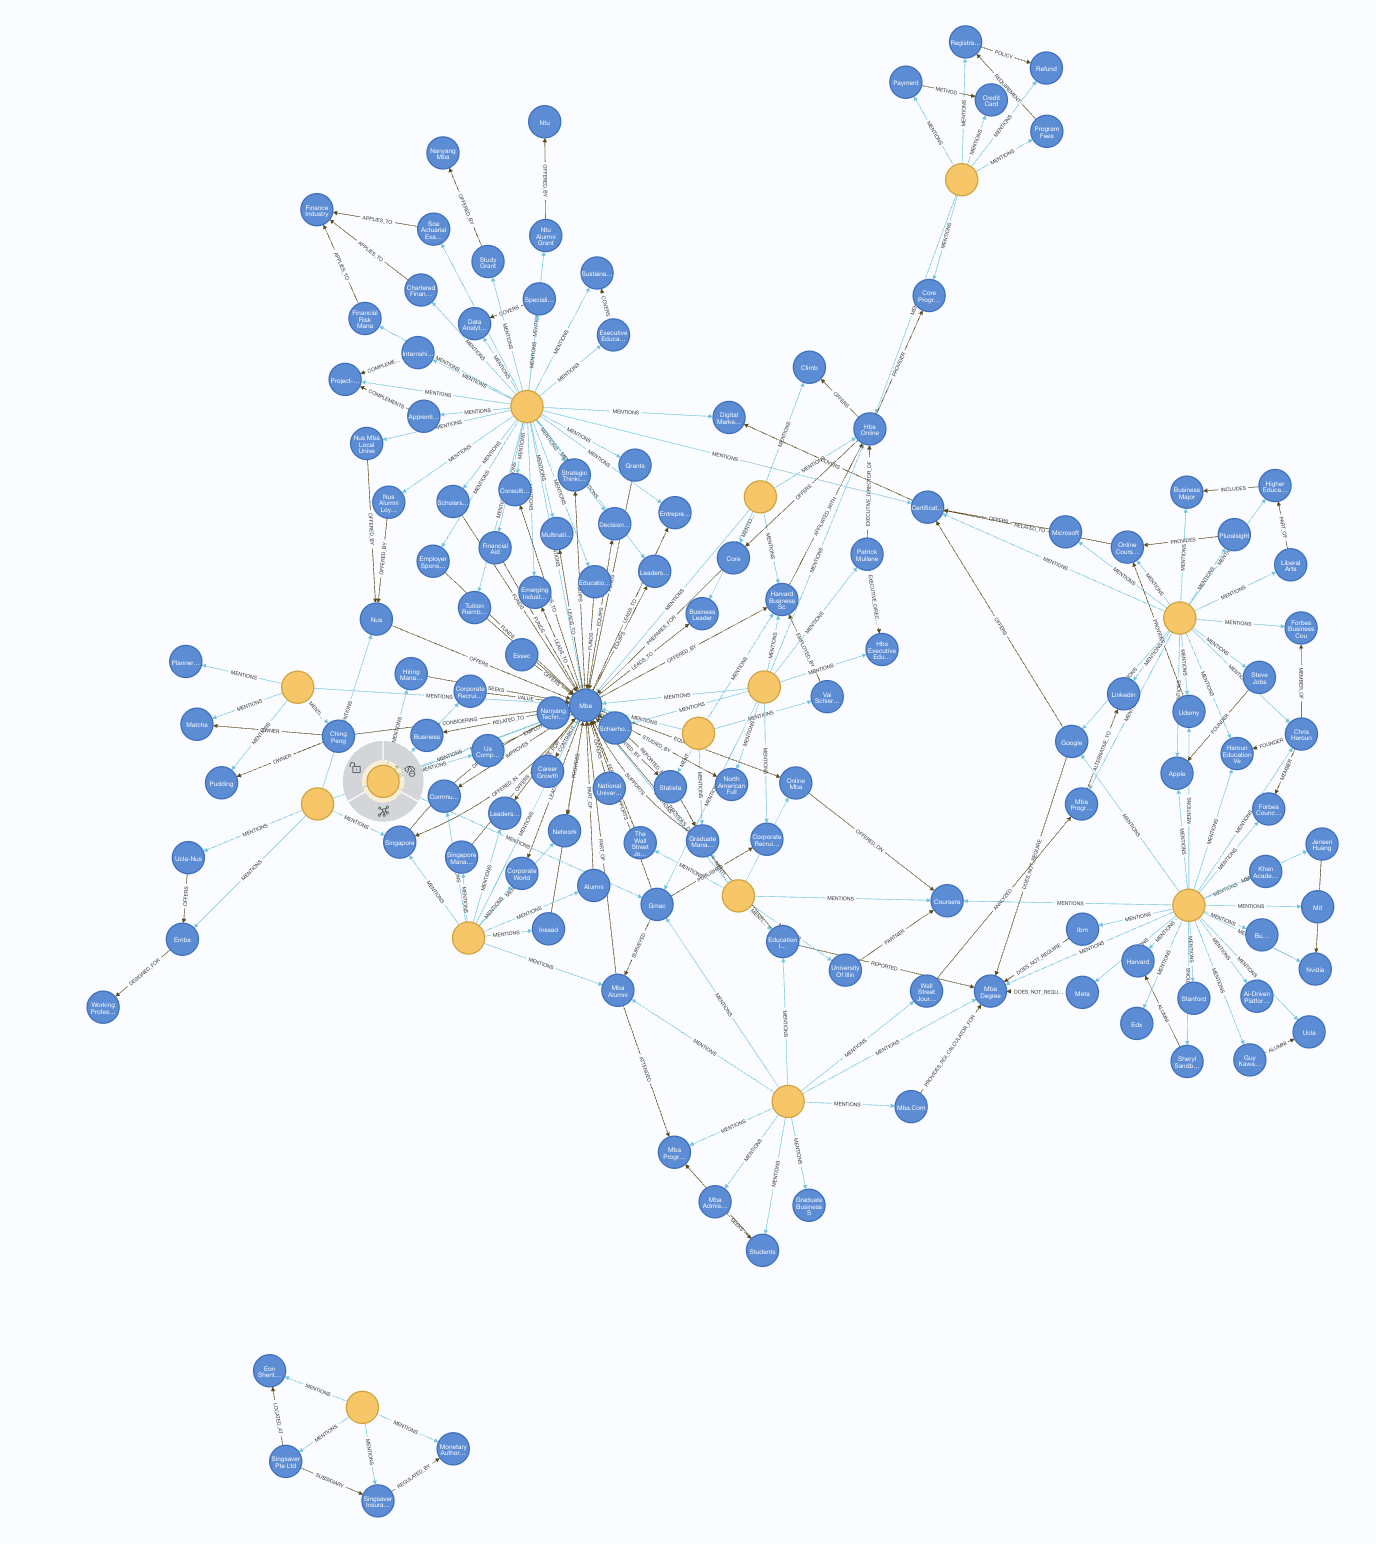

In [2]:
from IPython.display import Image

Image(filename="./images/full_kg.png")

Zooming in...

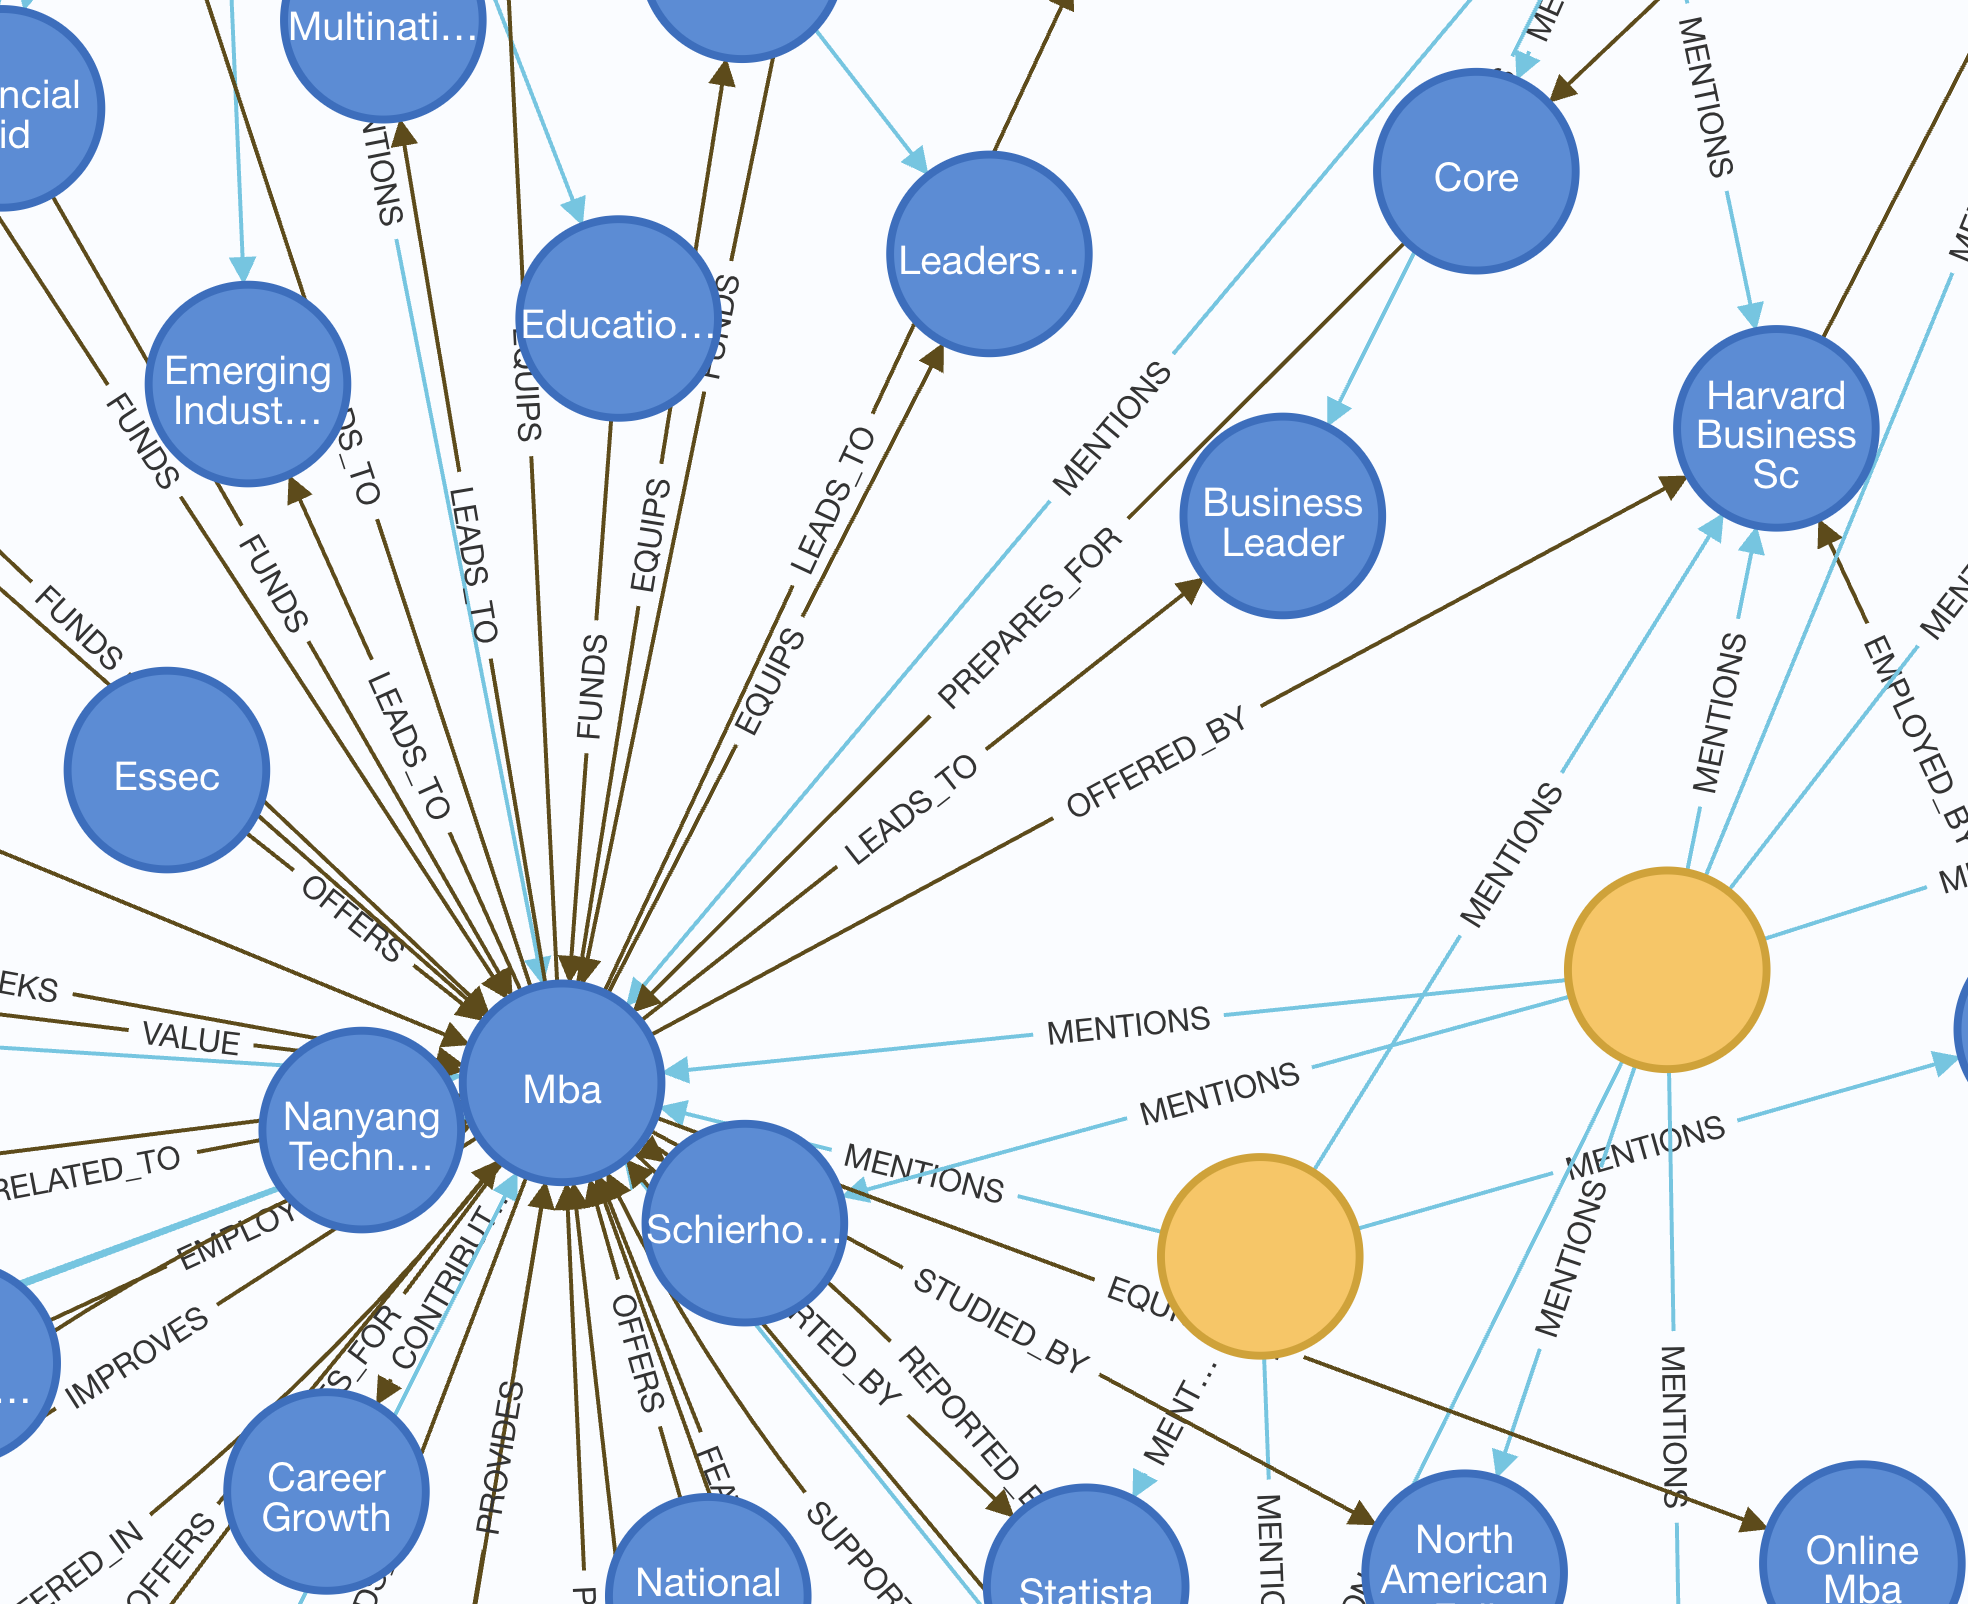

In [3]:
Image(filename="./images/full_kg_zoomed.png")

### Graph Querying
Time to have some fun and see what our graph can do!

In [27]:
from langchain_neo4j import GraphCypherQAChain

chain = GraphCypherQAChain.from_llm(
    llm, 
    graph=graph, 
    verbose=True, 
    return_intermediate_steps=True,
    allow_dangerous_requests=True
)

In [38]:
response = chain.invoke(
    {"query": "What are the considerations when taking an MBA?"}
)



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (n:MBA)-[:REQUIRES]->(r:Consideration) RETURN r.name


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.UnknownRelationshipTypeWarning} {category: UNRECOGNIZED} {title: The provided relationship type is not in the database.} {description: One of the relationship types in your query is not available in the database, make sure you didn't misspell it or that the label is available when you run this statement in your application (the missing relationship type is: REQUIRES)} {position: line: 1, column: 17, offset: 16} for query: 'MATCH (n:MBA)-[:REQUIRES]->(r:Consideration) RETURN r.name'
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.UnknownLabelWarning} {category: UNRECOGNIZED} {title: The provided label is not in the database.} {description: One of the labels in your query is not available in the database, make sure you didn't misspell it or that the label is available when you run this statement in your application (the missing label name

Full Context:
[]

> Finished chain.


In [39]:
from IPython.display import display, Markdown

display(Markdown(response['result']))

I don't know the answer.

In [40]:
response = chain.invoke(
    {"query": "What are the benefits of an MBA?"}
)

display(Markdown(response['result']))



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (n:MBA)-[:HAS_BENEFIT]->(b:Benefit) RETURN b.name


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.UnknownRelationshipTypeWarning} {category: UNRECOGNIZED} {title: The provided relationship type is not in the database.} {description: One of the relationship types in your query is not available in the database, make sure you didn't misspell it or that the label is available when you run this statement in your application (the missing relationship type is: HAS_BENEFIT)} {position: line: 1, column: 17, offset: 16} for query: 'MATCH (n:MBA)-[:HAS_BENEFIT]->(b:Benefit) RETURN b.name'
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.UnknownLabelWarning} {category: UNRECOGNIZED} {title: The provided label is not in the database.} {description: One of the labels in your query is not available in the database, make sure you didn't misspell it or that the label is available when you run this statement in your application (the missing label name

Full Context:
[]

> Finished chain.


I don't know the answer.

That's because we're trying to ping the graph using CypherQL! This is one of the gotchas when using Graphs for RAG, we should still be looking at a vector-based search as our first cut before traversing the graph because it's much more difficult to get working cypher queries from questions.

# Adding a vector component
We have to store the vector embeddings of the documents into a vector database. Neo4j has one too! How convenient

In [41]:
from langchain_neo4j import Neo4jVector
from langchain_ollama import OllamaEmbeddings

embeddings = OllamaEmbeddings(model="nomic-embed-text")

vector_index = Neo4jVector.from_existing_graph(
    embeddings,
    search_type="hybrid",
    node_label="Document",
    text_node_properties=["text"],
    embedding_node_property="embedding"
)

#### 🧠 Entity Extraction with Structured Output using LangChain and Pydantic

This cell sets up a structured entity extraction pipeline using LangChain's prompt templating and Pydantic's validation schema.

🔍 What It Does
Defines a Pydantic model (Entities) to strictly structure the output — here, a list of named entities (people, organizations, or businesses) from a given input.

Builds a ChatPromptTemplate that instructs an LLM to behave like an entity extractor.

Chains the prompt with the LLM, and wraps the output using the Entities schema to ensure consistent formatting and validation.

📦 Key Components
- Entities: A Pydantic class describing the structure of the desired output (names: List[str]).

- ChatPromptTemplate: Supplies a system-human prompt pair for clear instructions.

- llm.with_structured_output(Entities): Forces the LLM to return results conforming to the Entities model — no messy parsing needed.

✅ Result
Calling `entity_chain.invoke({"question": "Who founded OpenAI and where is it based?"})` would return something like:

`Entities(names=["OpenAI"])`
This is especially helpful for downstream tasks like knowledge graph querying, metadata enrichment, or targeted web crawling.

In [ ]:
from pydantic import BaseModel, Field
from typing import List

from langchain_core.prompts import ChatPromptTemplate

class Entities(BaseModel):
    """Identifying information about entities."""

    names: List[str] = Field(
        ...,
        description="All the person/s, organization/s, or business entities that appear in the text",
    )

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are extracting organization and person entities from the text.",
        ),
        (
            "human",
            "Use the given format to extract information from the following"
            "input: {question}",
        ),
    ]
)

entity_chain = prompt | llm.with_structured_output(Entities)

#### 🔎 Fuzzy Full-Text Search for Entity Matching in Neo4j
This cell prepares Neo4j for fuzzy entity lookups and defines a helper function to construct robust full-text search queries that tolerate typos and slight variations.

⚙️ What It Does
- Creates a Full-Text Index in Neo4j:
    - `CREATE FULLTEXT INDEX entity IF NOT EXISTS FOR (e:__Entity__) ON EACH [e.id]`
    - This enables efficient, text-based searching over the id property of nodes labeled `__Entity__`.

- Defines generate_full_text_query():

    - Prepares user input for fuzzy matching by cleaning it with remove_lucene_chars() (to avoid Lucene syntax errors).
    - Appends ~2 (Lucene fuzzy match operator allowing 2-character edits) to each word.
    - Joins them using AND to enforce conjunctive search — all words must appear in the match, but each can be slightly different.

🧪 Example
- `generate_full_text_query("Gooogle DeepMind")`
- `Output: "Gooogle~2 AND DeepMind~2"`
- This query can now be passed to Neo4j’s db.index.fulltext.queryNodes() for fault-tolerant graph retrieval.

💡 Use this approach when:
- Users may misspell names or entities.
- You want to search graph data for approximate matches.
- You’re building entity resolution or knowledge graph augmentation workflows.

In [ ]:
from langchain_neo4j.vectorstores.neo4j_vector import remove_lucene_chars

graph.query("CREATE FULLTEXT INDEX entity IF NOT EXISTS FOR (e:__Entity__) ON EACH [e.id]")

def generate_full_text_query(input: str) -> str:
    """
    Generates a fuzzy full-text search query from an input string.

    Each word in the input string is appended with a fuzzy match operator (`~2`)
    to tolerate up to two character differences (e.g., typos), and combined with
    logical AND operators for a strict conjunctive search.

    This is especially useful for querying search indexes or graph databases 
    when matching user-provided input against stored entities with possible 
    misspellings or slight variations.

    Args:
        input (str): The input string to be transformed into a full-text query.

    Returns:
        str: A constructed full-text search query with fuzzy match operators.
    """

    full_text_query = ""
    words = [el for el in remove_lucene_chars(input).split() if el]
    print(words)
    for word in words[:-1]:
        print(full_text_query)
        full_text_query += f" {word}~2 AND"
    full_text_query += f" {words[-1]}~2"
    print(f"Full text query generated: {full_text_query.strip()}")
    return full_text_query.strip()

#### 🔄 Structured + Unstructured Retrieval from Knowledge Sources
This cell defines two key functions that combine symbolic (graph-based) and neural (vector-based) retrieval to enrich context for downstream tasks like answering questions or generating insights.

📌 structured_retriever(question: str)
Purpose:
- Looks up the neighborhood of named entities in a Neo4j knowledge graph by:
- Extracting entities using a structured entity_chain.
- Generating fuzzy full-text queries to match potentially misspelled or similar names.
- Querying Neo4j using Cypher to retrieve both incoming and outgoing relationships with !MENTIONS edges.
- Formatting the results as plain text for context consumption.

🔎 This gives a symbolic, relational understanding of what/who is connected to each mentioned entity.

📌 retriever(question: str)
Purpose:
- Combines two modes of retrieval:

    - 🧠 Structured: Calls structured_retriever() to get symbolic facts and relationships from a Neo4j graph.

    - 🔍 Unstructured: Uses vector similarity search (vector_index.similarity_search) to retrieve semantically similar documents or passages based on the question.

- Returns a rich, formatted string that fuses both types of knowledge:

💡 When to Use This Pattern
Use this hybrid retrieval when:
- You want both factual relationships and contextual background.
- You want to explain the reasoning path.

In [ ]:
def structured_retriever(question: str) -> str:
    """
    Retrieves the structured neighborhood of entities mentioned in a question.

    This function performs the following steps:
    - Extracts named entities from the user's question using an entity extraction chain.
    - For each entity, performs a fuzzy full-text search against a graph database.
    - Collects and formats the relationships (incoming and outgoing) around each matched node.

    Args:
        question (str): The user's question from which to extract and retrieve related entity data.

    Returns:
        str: A formatted string of the graph relationships around the matched entities.
    """
    result = ""
    entities = entity_chain.invoke({"question": question})
    for entity in entities.names:
        # print("Querying graph...")
        response = graph.query(
            """CALL db.index.fulltext.queryNodes('entity', $query, 
            {limit:2})
            YIELD node,score
            CALL {
              MATCH (node)-[r:!MENTIONS]->(neighbor)
              RETURN node.id + ' - ' + type(r) + ' -> ' + neighbor.id AS 
              output
              UNION
              MATCH (node)<-[r:!MENTIONS]-(neighbor)
              RETURN neighbor.id + ' - ' + type(r) + ' -> ' +  node.id AS 
              output
            }
            RETURN output LIMIT 50
            """,
            {"query": generate_full_text_query(entity)},
        )
        result += "\n".join([el['output'] for el in response])
        # print(f"\n\nresult: {result}")
    return result

def retriever(question: str):
    """
    Retrieves both structured and unstructured data relevant to a given question.

    Combines:
    - Structured graph-based data from entity neighborhood lookups via `structured_retriever`.
    - Unstructured semantic matches from a vector index using similarity search.

    The combined result is a contextual block of structured relationships and
    relevant textual snippets for further processing or reasoning.

    Args:
        question (str): The user's query or natural language question.

    Returns:
        str: A combined context string including both structured and unstructured data.
    """
    structured_data = structured_retriever(question)
    unstructured_data = [el.page_content for el in vector_index.similarity_search(question, similarity_score_threshold=0.5)]
    final_data = f"""Structured data:
        {structured_data}
        Unstructured data:
        {"#Document ". join(unstructured_data)}
    """
    print(f"\n\n Final data in context: {final_data}")
    return final_data

#### 🔗 Components Breakdown
1. RunnableParallel
Runs two tasks in parallel:
- "context" → Pulls from the retriever(question) function (which combines graph-based and vector-based data).
- "question" → Passes through the original question unchanged via RunnablePassthrough().

2. ChatPromptTemplate
Constructs the prompt to be used by the runnable.

3. llm
Applies the language model to generate a context-aware response.

4. StrOutputParser()
Extracts the model’s reply as a plain string, cleaning up the output for easy downstream use.

In [45]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableParallel

template = """Answer the question based only on the following context:
{context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

chain = (
    RunnableParallel(
        {
            "context": retriever,
            "question": RunnablePassthrough(),
        }
    )
    | prompt
    | llm
    | StrOutputParser()
)

# RAG time!
Let's chat with our bot!

In [46]:
response = chain.invoke( "What are the benefits of an MBA?")

Search query: What are the benefits of an MBA?
Querying graph...
['MBA']
Full text query generated: MBA~2


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL () { ... }} {position: line: 4, column: 13, offset: 117} for query: "CALL db.index.fulltext.queryNodes('entity', $query, \n            {limit:2})\n            YIELD node,score\n            CALL {\n              MATCH (node)-[r:!MENTIONS]->(neighbor)\n              RETURN node.id + ' - ' + type(r) + ' -> ' + neighbor.id AS \n              output\n              UNION\n              MATCH (node)<-[r:!MENTIONS]-(neighbor)\n              RETURN neighbor.id + ' - ' + type(r) + ' -> ' +  node.id AS \n              output\n            }\n            RETURN output LIMIT 50\n            "




result: Chris Haroun - MEMBER -> Forbes Councils
Chris Haroun - FOUNDER -> Haroun Education Ventures, Inc.
Google - DOES_NOT_REQUIRE -> Mba Degree
Meta - DOES_NOT_REQUIRE -> Mba Degree
Ibm - DOES_NOT_REQUIRE -> Mba Degree
Sheryl Sandberg - ALUMNI -> Harvard
Guy Kawasaki - ALUMNI -> Ucla
Jensen Huang - FOUNDER -> Nvidia
Steve Jobs - FOUNDER -> Apple
Liberal Arts - PART_OF -> Higher Education
Higher Education - INCLUDES -> Business Major
Online Courses - RELATED_TO -> Certifications
Udemy - PROVIDES -> Online Courses
Pluralsight - PROVIDES -> Online Courses
Google - OFFERS -> Certifications
Microsoft - OFFERS -> Certifications
Mba Programs - ALTERNATIVE_TO -> Linkedin
Chris Haroun - MEMBER_OF -> Forbes Business Council
Mba - OFFERED_BY -> Harvard Business School
Vai Schierholtz - EMPLOYED_BY -> Harvard Business School
Mba - REPORTED_BY -> Statista
Mba - REPORTED_BY -> Graduate Management Admission Council
Mba - MENTIONED_BY -> Schierholtz
Gmac - PUBLISHED -> Corporate Recruiters Survey

In [47]:
display(Markdown(response))

The benefits of an MBA include:

1. **Career Acceleration**: An MBA can help expand and accelerate your career by teaching you how to solve complex problems, make decisions, and lead teams.
2. **Earning Potential**: An MBA can increase your earning potential, with MBA holders typically earning higher salaries than bachelor's degree holders.
3. **Connections**: An MBA program provides opportunities to develop strong connections with diverse individuals from around the world, including students, faculty, and alumni.
4. **Leadership Skills**: An MBA can equip you with leadership skills, such as strategic planning, managing people, goal setting, and driving an organization forward.
5. **Networking Opportunities**: An MBA program can provide access to career resources, networking opportunities, and executive coaching, which can lead to more lucrative career options.
6. **Improved Job Prospects**: An MBA can give you an edge in a competitive job market, with many employers valuing the skills and knowledge gained through an MBA program.
7. **Personal Growth**: An MBA can be a transformative experience that helps you develop new skills, gain new perspectives, and achieve personal growth.

Overall, an MBA can provide a strong foundation for career advancement, increased earning potential, and personal growth, making it a worthwhile investment for many individuals.

In [48]:
response = chain.invoke( "Is an MBA really effective?")
display(Markdown(response))

Search query: Is an MBA really effective?
Querying graph...
['MBA']
Full text query generated: MBA~2


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL () { ... }} {position: line: 4, column: 13, offset: 117} for query: "CALL db.index.fulltext.queryNodes('entity', $query, \n            {limit:2})\n            YIELD node,score\n            CALL {\n              MATCH (node)-[r:!MENTIONS]->(neighbor)\n              RETURN node.id + ' - ' + type(r) + ' -> ' + neighbor.id AS \n              output\n              UNION\n              MATCH (node)<-[r:!MENTIONS]-(neighbor)\n              RETURN neighbor.id + ' - ' + type(r) + ' -> ' +  node.id AS \n              output\n            }\n            RETURN output LIMIT 50\n            "




result: Chris Haroun - MEMBER -> Forbes Councils
Chris Haroun - FOUNDER -> Haroun Education Ventures, Inc.
Google - DOES_NOT_REQUIRE -> Mba Degree
Meta - DOES_NOT_REQUIRE -> Mba Degree
Ibm - DOES_NOT_REQUIRE -> Mba Degree
Sheryl Sandberg - ALUMNI -> Harvard
Guy Kawasaki - ALUMNI -> Ucla
Jensen Huang - FOUNDER -> Nvidia
Steve Jobs - FOUNDER -> Apple
Liberal Arts - PART_OF -> Higher Education
Higher Education - INCLUDES -> Business Major
Online Courses - RELATED_TO -> Certifications
Udemy - PROVIDES -> Online Courses
Pluralsight - PROVIDES -> Online Courses
Google - OFFERS -> Certifications
Microsoft - OFFERS -> Certifications
Mba Programs - ALTERNATIVE_TO -> Linkedin
Chris Haroun - MEMBER_OF -> Forbes Business Council
Mba - OFFERED_BY -> Harvard Business School
Vai Schierholtz - EMPLOYED_BY -> Harvard Business School
Mba - REPORTED_BY -> Statista
Mba - REPORTED_BY -> Graduate Management Admission Council
Mba - MENTIONED_BY -> Schierholtz
Gmac - PUBLISHED -> Corporate Recruiters Survey

According to the provided context, an MBA can be an effective investment for many people, particularly those pursuing a career in business. The benefits of an MBA include:

1. **Salary gains**: MBA graduates can earn higher salaries, with a median annual salary of $120,000 in 2024, compared to $69,320 for bachelor's degree holders.
2. **Career advancement opportunities**: An MBA can lead to career advancement, with 92% of US-based recruiters expecting to hire MBA graduates in 2023, and 86% of 2022 MBA graduates being employed upon graduation.
3. **Networking opportunities**: MBA programs offer valuable networking opportunities, including career resources, alumni networks, and executive coaching.
4. **Development of in-demand skills**: MBA programs help graduates acquire transferable skills, such as interpersonal skills, motivation and leadership, strategy and innovation, decision-making, and strategic and systems skills.
5. **Personal growth**: An MBA can be a transformative experience, helping individuals develop new perspectives, build relationships, and enhance their personal and professional lives.

However, the effectiveness of an MBA also depends on individual circumstances, such as career goals, location, and personal finances. It's essential to weigh the costs and benefits of an MBA program and consider factors like program reputation, curriculum, and alumni network before making a decision.

In [49]:
response = chain.invoke( "Are online MBAs less effective than traditional MBAs?")
display(Markdown(response))

Search query: Are online MBAs less effective than traditional MBAs?
Querying graph...
['online', 'MBAs']

Full text query generated: online~2 AND MBAs~2


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL () { ... }} {position: line: 4, column: 13, offset: 117} for query: "CALL db.index.fulltext.queryNodes('entity', $query, \n            {limit:2})\n            YIELD node,score\n            CALL {\n              MATCH (node)-[r:!MENTIONS]->(neighbor)\n              RETURN node.id + ' - ' + type(r) + ' -> ' + neighbor.id AS \n              output\n              UNION\n              MATCH (node)<-[r:!MENTIONS]-(neighbor)\n              RETURN neighbor.id + ' - ' + type(r) + ' -> ' +  node.id AS \n              output\n            }\n            RETURN output LIMIT 50\n            "




result: Chris Haroun - MEMBER -> Forbes Councils
Chris Haroun - FOUNDER -> Haroun Education Ventures, Inc.
Google - DOES_NOT_REQUIRE -> Mba Degree
Meta - DOES_NOT_REQUIRE -> Mba Degree
Ibm - DOES_NOT_REQUIRE -> Mba Degree
Sheryl Sandberg - ALUMNI -> Harvard
Guy Kawasaki - ALUMNI -> Ucla
Jensen Huang - FOUNDER -> Nvidia
Steve Jobs - FOUNDER -> Apple
Liberal Arts - PART_OF -> Higher Education
Higher Education - INCLUDES -> Business Major
Online Courses - RELATED_TO -> Certifications
Udemy - PROVIDES -> Online Courses
Pluralsight - PROVIDES -> Online Courses
Google - OFFERS -> Certifications
Microsoft - OFFERS -> Certifications
Mba Programs - ALTERNATIVE_TO -> Linkedin
Chris Haroun - MEMBER_OF -> Forbes Business Council
Mba - OFFERED_BY -> Harvard Business School
Vai Schierholtz - EMPLOYED_BY -> Harvard Business School
Mba - REPORTED_BY -> Statista
Mba - REPORTED_BY -> Graduate Management Admission Council
Mba - MENTIONED_BY -> Schierholtz
Gmac - PUBLISHED -> Corporate Recruiters Survey

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL () { ... }} {position: line: 4, column: 13, offset: 117} for query: "CALL db.index.fulltext.queryNodes('entity', $query, \n            {limit:2})\n            YIELD node,score\n            CALL {\n              MATCH (node)-[r:!MENTIONS]->(neighbor)\n              RETURN node.id + ' - ' + type(r) + ' -> ' + neighbor.id AS \n              output\n              UNION\n              MATCH (node)<-[r:!MENTIONS]-(neighbor)\n              RETURN neighbor.id + ' - ' + type(r) + ' -> ' +  node.id AS \n              output\n            }\n            RETURN output LIMIT 50\n            "




result: Chris Haroun - MEMBER -> Forbes Councils
Chris Haroun - FOUNDER -> Haroun Education Ventures, Inc.
Google - DOES_NOT_REQUIRE -> Mba Degree
Meta - DOES_NOT_REQUIRE -> Mba Degree
Ibm - DOES_NOT_REQUIRE -> Mba Degree
Sheryl Sandberg - ALUMNI -> Harvard
Guy Kawasaki - ALUMNI -> Ucla
Jensen Huang - FOUNDER -> Nvidia
Steve Jobs - FOUNDER -> Apple
Liberal Arts - PART_OF -> Higher Education
Higher Education - INCLUDES -> Business Major
Online Courses - RELATED_TO -> Certifications
Udemy - PROVIDES -> Online Courses
Pluralsight - PROVIDES -> Online Courses
Google - OFFERS -> Certifications
Microsoft - OFFERS -> Certifications
Mba Programs - ALTERNATIVE_TO -> Linkedin
Chris Haroun - MEMBER_OF -> Forbes Business Council
Mba - OFFERED_BY -> Harvard Business School
Vai Schierholtz - EMPLOYED_BY -> Harvard Business School
Mba - REPORTED_BY -> Statista
Mba - REPORTED_BY -> Graduate Management Admission Council
Mba - MENTIONED_BY -> Schierholtz
Gmac - PUBLISHED -> Corporate Recruiters Survey

The provided context does not explicitly state that online MBAs are less effective than traditional MBAs. In fact, it mentions that online MBAs offer the same education as their in-person counterparts but allow you to learn from anywhere with an internet connection, and they are often less expensive than on-campus options. This suggests that online MBAs can be a viable and potentially more affordable alternative to traditional MBAs, without necessarily being less effective.

## Working
Just code cells to show exploratory data analysis

In [ ]:
async def crawl_website(url: str):
    async with AsyncWebCrawler() as crawler:
        result = await crawler.arun(url)
    return result

### Forbes article schema

In [ ]:
forbes = asyncio.run(crawl_website(urls[0]))

[INIT].... → Crawl4AI 0.6.2
[FETCH]... ↓ https://www.forbes.com/councils/forbesbusinessco...3/19/reconsidering-the-mba-is-it-still-worth-it/  | ✓ | ⏱: 2.51s
[SCRAPE].. ◆ https://www.forbes.com/councils/forbesbusinessco...3/19/reconsidering-the-mba-is-it-still-worth-it/  | ✓ | ⏱: 0.06s
[COMPLETE] ● https://www.forbes.com/councils/forbesbusinessco...3/19/reconsidering-the-mba-is-it-still-worth-it/  | ✓ | ⏱: 2.58s


In [46]:
display(Markdown(forbes.markdown))

  * [Subscribe To Newsletters](https://account.forbes.com/newsletters)
  * [Trump Tracker](https://www.forbes.com/trump/)
  * [Billionaires](https://www.forbes.com/worlds-billionaires/)
Billionaires
[View All Billionaires](https://www.forbes.com/worlds-billionaires/)
    * [World's Billionaires](https://www.forbes.com/billionaires/)
    * [Forbes 400](https://www.forbes.com/forbes-400/)
    * [America's Richest Self-Made Women](https://www.forbes.com/self-made-women/)
    * [China's Richest](https://www.forbes.com/china-billionaires/)
    * [India's Richest](https://www.forbes.com/india-billionaires/)
    * [Indonesia's Richest](https://www.forbes.com/indonesia-billionaires/)
    * [Korea's Richest](https://www.forbes.com/korea-billionaires/list/)
    * [Thailand's Richest](https://www.forbes.com/thailand-billionaires/list/ )
    * [Japan's Richest](https://www.forbes.com/japan-billionaires/list/)
    * [Australia's Richest](https://www.forbes.com/australia-billionaires/)
    * [Taiwan's Richest](https://www.forbes.com/taiwan-billionaires/)
    * [Singapore's Richest](https://www.forbes.com/singapore-billionaires/)
    * [Philippines' Richest](https://www.forbes.com/philippines-billionaires/)
    * [Hong Kong's Richest](https://www.forbes.com/hong-kong-billionaires/)
    * [Malaysia's Richest](https://www.forbes.com/malaysia-billionaires/)
    * [Money & Politics ](https://www.forbes.com/money-politics/)
    * [2024 Election](https://www.forbes.com/2024-election/)
  * [Innovation](https://www.forbes.com/innovation/)
Innovation
[View All Innovation](https://www.forbes.com/innovation/)
    * [AI](https://www.forbes.com/ai/)
    * [Big Data](https://www.forbes.com/big-data/)
    * [Cloud](https://www.forbes.com/cloud/)
    * [Cloud 100](https://www.forbes.com/cloud100/)
    * [Consumer Tech](https://www.forbes.com/consumer-tech/)
    * [Creator Economy](https://www.forbes.com/creator-economy/)
    * [Cybersecurity](https://www.forbes.com/cybersecurity/)
    * [Digital Transformation](https://www.forbes.com/digital-transformation/)
    * [Enterprise Commerce](https://www.forbes.com/topics/enterprise-commerce/)
    * [Enterprise Security and Protection](https://www.forbes.com/topics/enterprise-security-and-protection/)
    * [Enterprise Tech](https://www.forbes.com/enterprise-tech/)
    * [Enterprise Growth Strategy](https://www.forbes.com/topics/enterprise-growth-strategy/)
    * [Future Of Work](https://www.forbes.com/future-of-work/)
    * [Gaming](https://www.forbes.com/gaming/)
    * [Healthcare](https://www.forbes.com/healthcare/)
    * [Innovation Rules](https://www.forbes.com/innovation-rules/)
    * [Retail Industry](https://www.forbes.com/topics/retail-industry/)
    * [SAP BrandVoice | Paid Program](https://www.forbes.com/sites/sap/)
    * [Science](https://www.forbes.com/science/)
    * [Social Media](https://www.forbes.com/social-media/)
    * [Sustainability & Climate](https://www.forbes.com/sustainability/)
    * [Transportation](https://www.forbes.com/transportation/)
    * [Venture Capital](https://www.forbes.com/venture-capital/)
    * [Technology](https://www.forbes.com/sites/technology/)
    * [VMware BrandVoice | Paid Program](https://www.forbes.com/sites/vmware/)
    * [TikTok BrandVoice | Paid Program](https://www.forbes.com/sites/tiktok/)
  * [Leadership](https://www.forbes.com/leadership/)
Leadership
[View All Leadership](https://www.forbes.com/leadership/)
    * [C-Suite](https://www.forbes.com/cxo/)
      * [CEO Network](https://www.forbes.com/ceo-network/)
      * [CFO Network](https://www.forbes.com/cfo-network/)
      * [CHRO Network](https://www.forbes.com/chro-network/)
      * [CIO Network](https://www.forbes.com/cio-network/)
      * [CMO Network](https://www.forbes.com/cmo-network/)
      * [Leadership Strategies](https://www.forbes.com/leadership-strategy/)
    * [Careers](https://www.forbes.com/careers/)
    * [Diversity, Equity & Inclusion](https://www.forbes.com/diversity-inclusion/)
    * [Education](https://www.forbes.com/education/)
    * [Forbes EQ | Paid Program](https://www.forbes.com/sites/forbeseq/)
    * [ForbesBLK](https://www.forbes.com/blk-leadership/)
    * [ForbesWomen](https://www.forbes.com/women-at-forbes/)
    * [Under 30](https://www.forbes.com/under30/)
    * [Working Remote](https://www.forbes.com/working-remote/)
    * [Over 50](https://www.forbes.com/over-50/)
    * [Deloitte BrandVoice | Paid Program](https://www.forbes.com/sites/deloitte/)
    * [Dell Technologies BrandVoice | Paid Program](https://www.forbes.com/sites/delltechnologies/)
    * [SAP BrandVoice | Paid Program](https://www.forbes.com/sites/sap/)
    * [Stand Together BrandVoice | Paid Program](https://www.forbes.com/sites/stand-together/)
  * [Money](https://www.forbes.com/money/)
Money
[View All Money](https://www.forbes.com/money/)
    * [Banking & Insurance](https://www.forbes.com/banking-insurance/)
    * [ETFs & Mutual Funds](https://www.forbes.com/etfs-mutual-funds/)
    * [Fintech](https://www.forbes.com/fintech/)
    * [Hedge Funds & Private Equity](https://www.forbes.com/hedge-funds-private-equity/)
    * [Investing](https://www.forbes.com/investing/)
    * [Investor Hub](https://www.forbes.com/sites/investor-hub/)
    * [Markets](https://www.forbes.com/markets/)
    * [Personal Finance](https://www.forbes.com/personal-finance/)
    * [Retirement](https://www.forbes.com/retirement/)
    * [Taxes](https://www.forbes.com/taxes/)
    * [Top Advisor | SHOOK](https://www.forbes.com/top-advisor-shook/ )
    * [Wealth Management](https://www.forbes.com/wealth-management/ )
  * Forbes Digital Assets
Forbes Digital Assets
    * [Home](https://www.forbes.com/digital-assets/)
    * [Web3 Community](https://www.forbes.com/digital-assets/community/)
    * [News](https://www.forbes.com/digital-assets/news/)
    * [Crypto Prices](https://www.forbes.com/digital-assets/crypto-prices/)
    * [NFT Prices](https://www.forbes.com/digital-assets/nft-prices/)
    * [Research](https://www.forbes.com/digital-assets/research/)
    * [Learn](https://www.forbes.com/digital-assets/learn/)
      * [Crypto Basics](https://www.forbes.com/digital-assets/learn/crypto-basics/)
      * [BTC](https://www.forbes.com/digital-assets/learn/btc/)
      * [DeFi](https://www.forbes.com/digital-assets/learn/defi/)
      * [Web3 Education](https://www.forbes.com/digital-assets/learn/web3-education/)
      * [NFTs](https://www.forbes.com/digital-assets/learn/nfts/)
      * [Crypto Investments](https://www.forbes.com/digital-assets/learn/crypto-investments/)
    * [Events](https://www.forbes.com/digital-assets/events/)
    * [Crypto Portfolios](https://www.forbes.com/digital-assets/crypto-advisor-portfolio/)
  * [Business](https://www.forbes.com/business/)
Business
[View All Business](https://www.forbes.com/business/)
    * [Aerospace & Defense](https://www.forbes.com/aerospace-defense/)
    * [Energy](https://www.forbes.com/energy/)
    * [Food & Drink](https://www.forbes.com/food-drink/)
    * [Hollywood & Entertainment](https://www.forbes.com/hollywood-entertainment/)
    * [Law](https://www.forbes.com/law/)
    * [Manufacturing](https://www.forbes.com/manufacturing/)
    * [Media](https://www.forbes.com/media/)
    * [Policy](https://www.forbes.com/policy/)
    * [Retail](https://www.forbes.com/retail/)
    * [SportsMoney](https://www.forbes.com/sportsmoney/)
    * [Entertainment Digest](https://www.forbes.com/sites/entertainment/)
  * [Small Business](https://www.forbes.com/small-business/)
Small Business
[View All Small Business](https://www.forbes.com/small-business/)
    * [Entrepreneurs](https://www.forbes.com/entrepreneurs/)
    * [Franchises](https://www.forbes.com/franchises/)
    * [Small Business Strategy](https://www.forbes.com/small-business-strategy/)
  * [Lifestyle](https://www.forbes.com/lifestyle/)
Lifestyle
[View All Lifestyle](https://www.forbes.com/lifestyle/)
    * [Arts](https://www.forbes.com/arts/)
    * [Boats & Planes](https://www.forbes.com/boats-planes/)
    * [Cars & Bikes](https://www.forbes.com/cars-bikes/)
    * [Dining](https://www.forbes.com/dining/)
    * [ForbesLife](https://www.forbes.com/forbeslife/)
    * [Forbes Travel Guide](https://www.forbes.com/forbes-travel-guide/)
    * [Spirits](https://www.forbes.com/spirits/)
    * [Style & Beauty](https://www.forbes.com/style-beauty/)
    * [Travel](https://www.forbes.com/travel/)
    * [Vices](https://www.forbes.com/vices/)
    * [Watches](https://www.forbes.com/watches-jewelry/)
  * [Real Estate](https://www.forbes.com/real-estate/)
Real Estate
[View All Real Estate](https://www.forbes.com/real-estate/)
    * [Commercial Real Estate](https://www.forbes.com/commercial-real-estate/)
    * [Forbes Global Properties](https://www.forbes.com/forbes-global-properties/)
    * [Residential Real Estate](https://www.forbes.com/residential-real-estate/)
  * [Forbes Vetted](https://www.forbes.com/vetted/)
Forbes Vetted
[View All Forbes Vetted](https://www.forbes.com/vetted/)
    * [Mattress & Sleep](https://www.forbes.com/vetted/mattress-sleep/)
      * [Bed Frames](https://www.forbes.com/vetted/mattress-sleep/bed-frames/)
      * [Mattresses](https://www.forbes.com/vetted/mattress-sleep/mattresses/)
      * [Mattress Toppers](https://www.forbes.com/vetted/mattress-sleep/mattress-toppers/)
      * [Pillows](https://www.forbes.com/vetted/mattress-sleep/pillows/)
      * [Sheets & Bedding](https://www.forbes.com/vetted/mattress-sleep/sheets-bedding/)
      * [Sleep Products](https://www.forbes.com/vetted/mattress-sleep/sleep-products/)
    * [Home](https://www.forbes.com/vetted/home/)
      * [Bathroom](https://www.forbes.com/vetted/home/bathroom/)
      * [Cleaning & Laundry](https://www.forbes.com/vetted/home/cleaning-laundry/)
      * [Decor](https://www.forbes.com/vetted/home/decor/)
      * [Furniture](https://www.forbes.com/vetted/home/furniture/)
      * [Heating & Cooling](https://www.forbes.com/vetted/home/heating-cooling/)
      * [Hobbies](https://www.forbes.com/vetted/home/hobbies/)
      * [Home Office](https://www.forbes.com/vetted/home-office/)
      * [Kitchen & Dining](https://www.forbes.com/vetted/home/kitchen-dining/)
      * [Outdoor](https://www.forbes.com/vetted/home/outdoor/)
      * [Pets](https://www.forbes.com/vetted/home/pets/)
      * [Storage & Organization](https://www.forbes.com/vetted/home/storage-organization/)
      * [Tools](https://www.forbes.com/vetted/home/tools/)
      * [Wine & Bar](https://www.forbes.com/vetted/home/wine-bar/)
    * [Fashion](https://www.forbes.com/vetted/fashion/)
      * [Accessories](https://www.forbes.com/vetted/fashion/accessories/)
      * [Clothing](https://www.forbes.com/vetted/fashion/clothing/)
      * [Eyewear](https://www.forbes.com/vetted/fashion/eyewear/)
      * [Footwear](https://www.forbes.com/vetted/fashion/footwear/)
      * [Jewelry](https://www.forbes.com/vetted/fashion/jewelry/)
      * [Handbags & Purses](https://www.forbes.com/vetted/fashion/handbags-purses/)
      * [Lingerie & Sleepwear](https://www.forbes.com/vetted/fashion/lingerie-sleepwear/)
      * [Outdoor & Fitness Apparel](https://www.forbes.com/vetted/fashion/outdoor-fitness-apparel/)
      * [Outerwear](https://www.forbes.com/vetted/fashion/outerwear/)
      * [Watches](https://www.forbes.com/vetted/fashion/watches/)
    * [Kids & Baby Gear](https://www.forbes.com/vetted/kids-baby-gear/)
      * [Baby Gear](https://www.forbes.com/vetted/kids-baby-gear/baby-gear/)
      * [Kids Clothes & Accessories](https://www.forbes.com/vetted/kids-baby-gear/kids-clothes-accessories/)
      * [Nursery](https://www.forbes.com/vetted/kids-baby-gear/nursery/)
      * [Pregnancy & Postpartum](https://www.forbes.com/vetted/kids-baby-gear/pregnancy-postpartum/)
      * [Toys & Books](https://www.forbes.com/vetted/kids-baby-gear/toys-books/)
    * [Gear](https://www.forbes.com/vetted/gear/)
      * [Apparel & Accessories](https://www.forbes.com/vetted/gear/apparel-accessories/)
      * [Bikes](https://www.forbes.com/vetted/gear/bikes/)
      * [Camping & Hiking](https://www.forbes.com/vetted/gear/camping-hiking/)
      * [Climbing](https://www.forbes.com/vetted/gear/climbing/)
      * [Fishing & Hunting](https://www.forbes.com/vetted/gear/fishing-hunting/)
      * [Fitness](https://www.forbes.com/vetted/gear/fitness/)
      * [Golf](https://www.forbes.com/vetted/gear/golf/)
      * [Running](https://www.forbes.com/vetted/gear/running/)
      * [Tennis & Racket Sports](https://www.forbes.com/vetted/gear/tennis-racket-sports/)
      * [Tools & Tech](https://www.forbes.com/vetted/gear/tools-tech/)
      * [Training & Recovery](https://ww.forbes.com/vetted/gear/training-recovery/)
      * [Water Sports](https://www.forbes.com/vetted/gear/water-sports/)
      * [Wellness](https://www.forbes.com/vetted/gear/wellness/)
      * [Winter Sports](https://www.forbes.com/vetted/gear/winter-sports/)
    * [Beauty & Grooming](https://www.forbes.com/vetted/beauty-grooming/)
      * [Haircare](https://www.forbes.com/vetted/beauty-grooming/haircare/)
      * [Makeup](https://www.forbes.com/vetted/beauty-grooming/makeup/)
      * [Nailcare](https://www.forbes.com/vetted/beauty-grooming/nailcare/)
      * [Shaving](https://www.forbes.com/vetted/beauty-grooming/shaving/)
      * [Skincare](https://www.forbes.com/vetted/beauty-grooming/skincare/)
      * [Personal Products](https://www.forbes.com/vetted/beauty-grooming/personal-products/)
      * [Wellness & Self Care](https://www.forbes.com/vetted/beauty-grooming/wellness-self-care/)
    * [Tech & Electronics](https://www.forbes.com/vetted/tech-electronics/)
      * [Audio](https://www.forbes.com/vetted/tech-electronics/audio/)
      * [Cameras](https://www.forbes.com/vetted/tech-electronics/cameras/)
      * [Computers, Tablets & Accessories](https://www.forbes.com/vetted/tech-electronics/computers-tablets-accessories/)
      * [Gaming](https://www.forbes.com/vetted/tech-electronics/gaming/)
      * [Home Office](https://www.forbes.com/vetted/tech-electronics/home-office/)
      * [Online Tools](https://www.forbes.com/vetted/tech-electronics/online-tools/)
      * [Smart Home Devices](https://www.forbes.com/vetted/tech-electronics/smart-home-devices/)
      * [Smartphones, Smartwatches & Accessories](https://www.forbes.com/vetted/tech-electronics/smartphones-smartwatches-accessories/)
      * [Streaming](https://www.forbes.com/vetted/tech-electronics/streaming/)
      * [TVs](https://www.forbes.com/vetted/tech-electronics/tvs/)
    * [Travel](https://www.forbes.com/vetted/travel/)
      * [Cruises](https://www.forbes.com/vetted/travel/cruises/)
      * [Hotels & Lodging](https://www.forbes.com/vetted/travel/hotels-lodging/)
      * [Luggage](https://www.forbes.com/vetted/travel/luggage/)
      * [Travel Products](https://www.forbes.com/vetted/travel/travel-products/)
    * [Gifts](https://www.forbes.com/vetted/gifts/)
      * [Father's Day](https://www.forbes.com/vetted/gifts/fathers-day/)
      * [Holiday](https://www.forbes.com/vetted/gifts/holiday/)
      * [Mother's Day](https://www.forbes.com/vetted/gifts/mothers-day/)
      * [Valentine's Day](https://www.forbes.com/vetted/gifts/valentines-day/)
      * [Wedding](https://www.forbes.com/vetted/gifts/wedding/)
    * [Deals](https://www.forbes.com/vetted/deals/)
      * [Black Friday](https://www.forbes.com/vetted/deals/black-friday/)
      * [Cyber Monday](https://www.forbes.com/vetted/deals/cyber-monday/)
      * [Amazon Prime Day](https://www.forbes.com/vetted/deals/amazon-prime-day/)
      * [Beauty & Grooming](https://www.forbes.com/vetted/deals/beauty-grooming/)
      * [Big Sales](https://www.forbes.com/vetted/deals/big-sales/)
      * [Fashion](https://www.forbes.com/vetted/deals/fashion/)
      * [Gear](https://www.forbes.com/vetted/deals/gear/)
      * [Home](https://www.forbes.com/vetted/deals/home/)
      * [Tech & Electronics](https://www.forbes.com/vetted/deals/tech-electronics/)
      * [Travel Deals](https://www.forbes.com/vetted/deals/travel-deals/)
      * [Mattress & Sleep](https://www.forbes.com/vetted/deals/mattress-sleep/)
  * [Coupons](https://www.forbescoupons.com/)
Coupons
[View All Coupons](https://www.forbescoupons.com/)
    * [Amazon](https://www.forbescoupons.com/brand/amazon/)
    * [Asics](https://www.forbescoupons.com/brand/asics/)
    * [Yeti](https://www.forbescoupons.com/brand/yeti/)
    * [Frontgate](https://www.forbescoupons.com/brand/frontgate/)
    * [DreamCloud](https://www.forbescoupons.com/brand/dreamcloud/)
    * [Blue Nile](https://www.forbescoupons.com/brand/blue-nile/)
    * [Booking.com](https://www.forbescoupons.com/brand/booking-com/)
    * [Ulta Beauty](https://www.forbescoupons.com/brand/ulta-beauty/)
    * [Zappos](https://www.forbescoupons.com/brand/zappos/)
    * [Brooklinen](https://www.forbescoupons.com/brand/brooklinen/)
  * [Forbes 101](https://www.forbes.com/forbes-101/)
  * Advisor
Advisor
    * [Best Credit Cards Of 2025](https://www.forbes.com/advisor/credit-cards/best-credit-cards/)
    * [Compare Credit Cards](https://www.forbes.com/advisor/credit-cards/compare/)
    * [Balance Transfer Credit Cards](https://www.forbes.com/advisor/credit-cards/best/balance-transfer/)
    * [Cash Back Credit Cards](https://www.forbes.com/advisor/credit-cards/best/cash-back/)
    * [Travel Credit Cards](https://www.forbes.com/advisor/credit-cards/best-travel-credit-cards/)
    * [Business Credit Cards](https://www.forbes.com/advisor/credit-cards/best/business/)
    * [Mortgages & Loans](https://www.forbes.com/advisor/mortgages/)
      * [Best Mortgage Lenders](https://www.forbes.com/advisor/mortgages/best-mortgage-lenders/)
      * [Today's Mortgage Rates](https://www.forbes.com/advisor/mortgages/mortgage-rates/)
      * [Today's Refinance Rates](https://www.forbes.com/advisor/mortgages/refinance/refinance-rates/)
      * [Best Personal Loans](https://www.forbes.com/advisor/personal-loans/best-personal-loans/)
      * [Loans For Bad Credit](https://www.forbes.com/advisor/personal-loans/bad-credit-loans/)
      * [Best Debt Consolidation Loans](https://www.forbes.com/advisor/personal-loans/debt-consolidation-loans/)
      * [Best Student Loan Lenders](https://www.forbes.com/advisor/student-loans/best-private-student-loans/)
      * [Best Student Loan Refinance Lenders](https://www.forbes.com/advisor/student-loans/best-student-loan-refinance-lenders/)
      * [Business Loans](https://www.forbes.com/advisor/business-loans/best-small-business-loans/)
    * [Banking](https://www.forbes.com/advisor/banking/)
      * [Best Online Banks](https://www.forbes.com/advisor/banking/best-online-banks/)
      * [CD Rates](https://www.forbes.com/advisor/banking/cds/best-cd-rates/)
      * [High-Yield Savings Accounts](https://www.forbes.com/advisor/banking/savings/best-high-yield-savings-accounts/)
      * [Money Market Account](https://www.forbes.com/advisor/banking/money-market-account/best-money-market-accounts/)
    * [Life Insurance](https://www.forbes.com/advisor/life-insurance/best-life-insurance-companies/)
    * [Cheap Life Insurance](https://www.forbes.com/advisor/life-insurance/cheap-life-insurance/)
    * [No Exam Life Insurance](https://www.forbes.com/advisor/life-insurance/best-no-exam-life-insurance/)
    * [Travel Insurance](https://www.forbes.com/advisor/travel-insurance/best-travel-insurance-companies/)
    * [Covid-19 Travel Insurance](https://www.forbes.com/advisor/travel-insurance/best-pandemic-travel-insurance/)
    * [Cheap Travel Insurance Companies](https://www.forbes.com/advisor/travel-insurance/cheap-travel-insurance/)
    * [Best Car Insurance](https://www.forbes.com/advisor/car-insurance/best-car-insurance-companies/)
    * [Compare Car Insurance Quotes](https://www.forbes.com/advisor/car-insurance/car-insurance-quotes/)
    * [Cost Of Car Insurance](https://www.forbes.com/advisor/car-insurance/average-cost-of-car-insurance/)
    * [Cheap Car Insurance](https://www.forbes.com/advisor/car-insurance/cheapest-car-insurance/)
    * [Pet Insurance](https://www.forbes.com/advisor/pet-insurance/best-pet-insurance/)
    * [How Much Is Pet Insurance?](https://www.forbes.com/advisor/pet-insurance/pet-insurance-cost/)
    * [Cheap Pet Insurance](https://www.forbes.com/advisor/pet-insurance/best-cheap-pet-insurance/)
    * [Business Services](https://www.forbes.com/advisor/business/)
      * [Best LLC Services](https://www.forbes.com/advisor/business/best-llc-service/)
      * [Best Registered Agent Services](https://www.forbes.com/advisor/business/best-registered-agent-services/)
      * [How To Set Up An LLC](https://www.forbes.com/advisor/business/how-to-set-up-an-llc-in-7-steps/)
      * [How To Start A Business](https://www.forbes.com/advisor/business/how-to-start-a-business/)
      * [Cost To Start An LLC](https://www.forbes.com/advisor/business/cost-to-form-llc/)
      * [Best Payroll Services](https://www.forbes.com/advisor/business/software/best-payroll-services/)
      * [Best HR Software](https://www.forbes.com/advisor/business/software/best-human-resource-management-systems/)
      * [Best HRIS Systems](https://www.forbes.com/advisor/business/software/hris-systems/)
      * [Best PEO Services](https://www.forbes.com/advisor/business/software/best-peo-services/)
      * [Best Applicant Tracking Systems](https://www.forbes.com/advisor/business/best-applicant-tracking-systems/)
      * [Best Website Builders](https://www.forbes.com/advisor/business/software/best-website-builders/)
      * [Best Web Hosting Services](https://www.forbes.com/advisor/business/software/best-web-hosting-services/)
      * [Best Domain Registrar](https://www.forbes.com/advisor/business/software/best-domain-registrar/)
      * [Best Ecommerce Platform](https://www.forbes.com/advisor/business/software/best-ecommerce-platform/)
      * [Best Landing Page Builder](https://www.forbes.com/advisor/business/software/best-landing-page-builder/)
      * [Best VoIP Service](https://www.forbes.com/advisor/business/software/best-voip-service/)
      * [What Is VoIP?](https://www.forbes.com/advisor/business/software/what-voip/ )
      * [Best Answering Services](https://www.forbes.com/advisor/business/software/best-answering-services/)
      * [Best Call Center Software](https://www.forbes.com/advisor/business/software/best-call-center-software/)
      * [Best Cloud Phone System](https://www.forbes.com/advisor/business/cloud-phone-system/)
      * [Best Project Management Software](https://www.forbes.com/advisor/business/software/best-project-management-software/)
      * [Free Project Management Software](https://www.forbes.com/advisor/business/software/free-project-management-software/)
      * [Best Task Management Software](https://www.forbes.com/advisor/business/software/best-task-management-software/)
      * [Free Task Management Software](https://www.forbes.com/advisor/business/software/free-task-management-software/)
      * [Best Gantt Chart Software](https://www.forbes.com/advisor/business/software/best-gantt-chart-software/)
      * [Best VPN](https://www.forbes.com/advisor/business/software/best-vpn/)
      * [Best Free VPN](https://www.forbes.com/advisor/business/best-free-vpn/)
      * [Best Cheap VPN](https://www.forbes.com/advisor/business/software/best-cheap-vpn/)
      * [Best Antivirus Software](https://www.forbes.com/advisor/business/software/best-antivirus-software/)
      * [Best Password Managers](https://www.forbes.com/advisor/business/software/best-password-managers/)
    * [Home Services](https://www.forbes.com/home-improvement/)
      * [Best Moving Companies](https://www.forbes.com/home-improvement/moving-services/best-moving-companies/)
      * [Best Long Distance Moving Companies](https://www.forbes.com/home-improvement/moving-services/best-long-distance-moving-companies/)
      * [Best Car Shipping Companies](https://www.forbes.com/home-improvement/moving-services/best-car-shipping-companies/)
      * [Best Interstate Moving Companies](https://www.forbes.com/home-improvement/moving-services/best-interstate-moving-companies/)
      * [How Much Do Movers Cost?](https://www.forbes.com/home-improvement/moving-services/movers-and-packers-cost/)
      * [Best Home Warranty Companies](https://www.forbes.com/home-improvement/home-warranty/best-home-warranty-companies/)
      * [Cheapest Home Warranty Companies](https://www.forbes.com/home-improvement/home-warranty/cheapest-warranty-companies/)
      * [Are Home Warranties Worth It?](https://www.forbes.com/home-improvement/home-warranty/are-home-warranties-worth-it/)
      * [Home Warranty Cost](https://www.forbes.com/home-improvement/home-warranty/home-warranty-cost/)
      * [Best Home Appliance Insurance](https://www.forbes.com/home-improvement/home-warranty/best-home-appliance-insurance/)
      * [Best Solar Companies](https://www.forbes.com/home-improvement/solar/best-solar-companies/)
      * [Best Solar Panels](https://www.forbes.com/home-improvement/solar/best-solar-panels/)
      * [Cost Of Solar Panels](https://www.forbes.com/home-improvement/solar/cost-of-solar-panels/)
      * [Solar Tax Credit By State](https://www.forbes.com/home-improvement/solar/solar-tax-credit-by-state/)
      * [Are Solar Panels Worth It?](https://www.forbes.com/home-improvement/solar/are-solar-panels-worth-it/)
      * [Best Pest Control Companies](https://www.forbes.com/home-improvement/pest-control/best-pest-control-companies/)
      * [Best Termite Control Companies](https://www.forbes.com/home-improvement/pest-control/best-termite-control-companies/)
      * [Best Mosquito Control Companies](https://www.forbes.com/home-improvement/pest-control/best-mosquito-control-companies/)
      * [Pest Control Cost](https://www.forbes.com/home-improvement/pest-control/pest-control-cost/)
      * [How Much Do Exterminators Cost?](https://www.forbes.com/home-improvement/pest-control/how-much-does-exterminator-cost/)
      * [Best Home Security Companies](https://www.forbes.com/home-improvement/home-security/best-home-security-companies/)
      * [Best Home Security Systems](https://www.forbes.com/home-improvement/home-security/best-home-security-systems/)
      * [Home Security System Cost](https://www.forbes.com/home-improvement/home-security/home-security-system-cost/)
      * [Cheapest Home Security Systems](https://www.forbes.com/home-improvement/home-security/cheapest-home-security-systems/)
      * [Best Wireless Home Security Systems](https://www.forbes.com/home-improvement/home-security/best-wireless-home-security-system/)
      * [Best Internet Providers](https://www.forbes.com/home-improvement/internet/best-internet-providers/)
      * [Cheapest Internet Plans](https://www.forbes.com/home-improvement/internet/cheapest-internet-plans/)
      * [Fastest High Speed Internet Providers](https://www.forbes.com/home-improvement/internet/fastest-high-speed-internet-provider/)
      * [Best Internet Only Plans](https://www.forbes.com/home-improvement/internet/best-internet-only-plans/)
      * [Best Fiber Internet Providers](https://www.forbes.com/home-improvement/internet/best-fiber-internet-providers/)
    * [Education](https://www.forbes.com/advisor/education/)
    * [Forbes Advisor UK](https://www.forbes.com/uk/advisor/)
  * Health
Health
    * [Healthy Aging](https://www.forbes.com/health/healthy-aging/)
    * [Best Medical Alert Systems](https://www.forbes.com/health/medical-alert-systems/best-medical-alert-systems/)
    * [Medicare](https://www.forbes.com/health/medicare/)
    * [Medicare Advantage Plans](https://www.forbes.com/health/medicare/best-medicare-advantage-providers/)
    * [Medicare Supplement Plans](https://www.forbes.com/health/medicare/best-medicare-supplement-providers/)
    * [Medicare Advantage By State](https://www.forbes.com/health/medicare/medicare-advantage-by-state/)
    * [Health Insurance](https://www.forbes.com/advisor/health-insurance/best-health-insurance-companies/)
    * [Hearing Aids](https://www.forbes.com/health/hearing-aids/)
    * [Best Hearing Aids](https://www.forbes.com/health/hearing-aids/best-hearing-aids/)
    * [Senior Living](https://www.forbes.com/health/senior-living/)
    * [Mind](https://www.forbes.com/health/mind/)
    * [Best Online Therapy](https://www.forbes.com/health/mind/best-online-therapy/)
    * [Best CBD Gummies](https://www.forbes.com/health/cbd/best-cbd-gummies/)
    * [Best CBD Oil](https://www.forbes.com/health/cbd/best-cbd-oil/)
    * [Best Protein Powders](https://www.forbes.com/health/supplements/best-protein-powders/)
  * [Lists](https://www.forbes.com/lists/list-directory/)
  * [Video](https://www.forbes.com/video/)
  * Newsletters
Newsletters
    * [Crypto Confidential](http://bit.ly/2Y2rVX8)
    * [Editorial Newsletters](https://account.forbes.com/newsletters/?utm_source=forbes&utm_medium=featured&utm_campaign=navigation)
  * [Forbes Games](https://www.forbes.com/games/)
Forbes Games
[View All Forbes Games](https://www.forbes.com/games/)
    * [Frase by Forbes](https://www.forbes.com/frase/)
    * [Pinpoint by LinkedIn](https://www.forbes.com/games/pinpoint/)
    * [Queens by LinkedIn](https://www.forbes.com/games/queens/)
    * [Crossclimb by LinkedIn](https://www.forbes.com/games/crossclimb/)
  * Forbes Magazine
Forbes Magazine
    * [Forbes Asia](https://www.forbes.com/forbesasia/#7cb46d1d2f95)
    * [Free Issue of Forbes](https://w1.buysub.com/pubs/B4/FRB/16-forbes_relaunch_landingpage_2freetrial.jsp?cds_mag_code=FRB&cds_page_id=241223)
  * Latest
Latest
    * [Coronavirus Coverage](https://www.forbes.com/coronavirus/)
    * [Daily Cover Stories](https://www.forbes.com/daily-cover-stories/)
    * [Dark Capital](https://www.forbes.com/dark-capital/)
    * [Editors' Picks](https://www.forbes.com/editors-picks/)
  * [Breaking News](https://www.forbes.com/news/)
  * Featured
Featured
    * [The Capital of Quantum | Paid Program](https://www.forbes.com/sites/state-of-maryland/2025/05/09/the-capital-of-quantum-how-maryland-plans-to-power-tomorrows-tech/)
    * [The New Industrial Identity: The Power Of Digitalization And Automation In America | Paid Program](https://www.forbes.com/sites/schneiderelectric/2025/05/05/the-new-industrial-identity/)
    * [Presented by Invesco QQQ: The Three Ps Of Success Purpose, Persistence And Passion | Paid Program](https://www.forbes.com/sites/robertdaugherty/2025/05/07/the-three-ps-of-success-purpose-persistence-and-passion/)
    * [2025 Best-In-State Wealth Advisors List](https://www.forbes.com/lists/best-in-state-wealth-advisors/)
    * [2025 America's Top Women Wealth Advisors](https://www.forbes.com/lists/top-women-advisors/)
    * [AI’s Nuanced Impact And A Quest To Quantify It](https://www.forbes.com/sites/forbes-research/2023/10/26/c-suite-data-reveals-ais-nuanced-impact--a-quest-to-quantify-it/)
    * [DNA of Success](https://www.forbes.com/sites/forbesvideo/2023/11/01/dna-of-success-2023/)
    * [Embracing And Bracing For AI](https://www.forbes.com/sites/forbes-research/2023/10/26/new-forbes-survey-reveals-how-executives-are-embracing---and-bracing-for---ai/)
    * [Facing A Volatile Market, C-Suites Look To The CFO For Strategic Guidance](https://www.forbes.com/sites/forbes-research/2023/11/01/facing-a-volatile-market-c-suites-look-to-the-cfo-for-strategic-guidance/)
    * [Forbes Research: 2023 Small Business Survey](https://www.forbes.com/sites/forbes-research/2023/06/07/resiliency-and-ingenuity-revealed-in-new-forbes-small-business-research/)
    * [Hyoeun Kim On LG's Brand Promise, "Life's Good" | Paid Program](https://www.forbes.com/video/5dd30175-916e-4349-9cab-564a384e45da/hyoeun-kim-on-lgs-brand-promise-lifes-good/)
    * [Your Four-Part Blueprint To Unlock AI Value In 2025 | Paid Program](https://www.forbes.com/sites/avanade/2025/02/05/your-four-part-blueprint-to-unlock-ai-value-in-2025/)
    * [Diners Club International Celebrates 75 Years | Paid Program](https://www.forbes.com/sites/diners-club-international/2025/02/14/diners-club-international-celebrates-75-years/)
    * [Celebrating The Power Of Partnership: Why Teamwork Is Key In the Fight Against Cancer | Paid Program](https://www.forbes.com/sites/american-cancer-society/2025/03/12/celebrating-the-power-of-partnership/)
    * [Protecting What Matters Most: How Gerber Life Insurance Offers Affordable Coverage For Your Whole Family | Paid Program](https://www.forbes.com/sites/gerber-life-insurance/2025/03/14/protecting-what-matters-most/)
    * [Presented by EY - Beyond The Blueprint: How These Four CEOs Built Billion-Dollar Businesses | Paid Program](https://www.forbes.com/sites/luisakroll/2025/03/17/beyond-the-blueprint-how-these-four-ceos-built-billion-dollar-businesses/)
    * [2/3 By 2030: Philip Morris International Marks A Milestone And Aims For A Smoke-Free Future | Paid Program](https://www.forbes.com/sites/philip-morris-international/2025/04/07/23-by-2030/)
    * [2025 America's Top Wealth Advisors](https://www.forbes.com/lists/top-wealth-advisors/)
    * [Forbes Insights: Your Guide To Marketing In The Era Of AI | Paid Program](https://www.forbes.com/sites/insights-adobe-microsoft/2025/03/31/your-guide-to-marketing-in-the-era-of-ai/)
    * [The Undergrad's New Journey To Real-World Ready | Paid Program](https://www.forbes.com/sites/boston-university-questrom-school-of-business/2025/04/09/the-undergrads-new-journey-to-real-world-ready/)
    * [Forbes Insights: Your Five-Step Strategy To Unleash AI’s Value In Marketing | Paid Program](https://www.forbes.com/sites/insights-adobe-microsoft/2025/04/09/your-five-step-strategy-to-unleash-ais-value-in-marketing/)
    * [Forbes Video Series: AI 50](https://www.forbes.com/sites/forbesvideo/2025/04/10/ai-50/)
    * [AI 50 List](https://www.forbes.com/lists/ai50/)
    * [By The Numbers: Meet The Forbes 30 Under 30 Europe Class Of 2025](https://www.forbes.com/30-under-30/2025/europe/)
    * [United To End Blood Cancer: Meet The Leaders Turning Passion Into Progress | Paid Program](https://www.forbes.com/sites/theleukemialymphomasociety/2025/04/15/united-to-end-blood-cancer-meet-the-leaders-turning-passion-into-progress/)
    * [United To Save Lives: Meet The Executive Leaders Dedicated To Building A World Without Blood Cancer | Paid Program](https://www.forbes.com/sites/theleukemialymphomasociety/2025/05/09/united-to-save-lives/)
  * [Advertise with Forbes](https://www.forbes.com/connect/)
  * [Forbes Licensing & Syndication](https://www.forbes.com/connect/content-partnerships/)
  * [Report a Security Issue](https://www.forbes.com/contact/)
  * [Editorial Values and Standards](https://www.forbes.com/sites/forbesstaff/article/forbes-editorial-values-and-standards)
  * Site Feedback
  * [Contact Us](https://www.forbes.com/contact/)
  * [Careers at Forbes](https://www.forbes.com/careers-at-forbes/)
  * [Tips](https://www.forbes.com/tips/)
  * Corrections
  * [Privacy](https://www.forbes.com/fdc/privacy.html)
  * [Do Not Sell My Personal Information](https://www.forbes.com/consent/editprivacy/?consent_do_not_sell=true)
  * [Terms](https://www.forbes.com/terms/)
  * [AdChoices](https://youradchoices.com/control)
  * [Reprints & Permissions](https://www.parsintl.com/publication/forbes/)
  * © 2025 Forbes Media LLC. All Rights Reserved.


[Subscribe To Newsletters](https://account.forbes.com/newsletters)
[](https://www.forbes.com/)
[](https://www.forbes.com/search/)
[](https://www.forbes.com/)
Reconsidering The MBA: Is It Still Worth It?
By[Chris Haroun](https://www.forbes.com/councils/forbesbusinesscouncil/people/chrisharoun/)
for [Forbes Business Council](https://www.forbes.com/councils/forbesbusinesscouncil/)
COUNCIL POST | Membership (fee-based)
Share
Save
[Small Business](https://www.forbes.com/small-business/)
# Reconsidering The MBA: Is It Still Worth It?
By[Chris Haroun](https://www.forbes.com/councils/forbesbusinesscouncil/people/chrisharoun/),
Forbes Councils Member. 
for [Forbes Business Council](https://www.forbes.com/councils/forbesbusinesscouncil/)
COUNCIL POST
Expertise from Forbes Councils members, operated under license. Opinions expressed are those of the author.
| Membership (fee-based)
Mar 19, 2025, 02:58pm EDT
Share
Save
 _Founder and CEO of_[ _Haroun Education Ventures, Inc._](https://harouneducationventures.com/)
![ ](https://imageio.forbes.com/specials-images/imageserve/67db135c72f4601c8baa410d//960x0.jpg?format=jpg&width=144)
getty
Once upon a time, an MBA degree, especially from a top university, was considered a golden ticket. The idea was simple: Invest the time and money in a prestigious graduate degree in business and doors would fly open to high-paying jobs and leadership roles in business, finance or technology.
But that’s no longer the case. Many top companies, including Google, Meta and IBM, don’t require a university degree at all anymore, let alone an MBA. The skills taught in traditional business programs are increasingly seen as outdated, and employers are shifting their focus to creativity, adaptability and real-world experience. That’s why I advise taking a hard look at whether an extremely expensive traditional two-year MBA from an accredited university is still worth the time and money.
PROMOTED
## The Declining Value Of A Degree
Let’s be honest: Many of the skills taught in business school aren’t as relevant as they once were. What’s missing? Essential skills like interviewing, selling, networking and managing personal finances. In the end, many MBA programs aren’t teaching students how to actually start and run a company, let alone how to make the most of the modern job market.
Then there’s the opportunity cost. Enrolling in a full-time MBA means years of lost wages and a tuition bill that easily tops $100,000 at the best schools. That’s a steep price for an education that isn’t keeping up with industry demands. [_According to reports_](https://www.spritzlerreport.com/post/even-harvard-m-b-a-s-are-struggling-to-land-jobs), more than a dozen top-tier MBA programs are having their worst job placement outcomes in recent memory.
[_Even high-profile MBA holders themselves are skeptical_](https://medium.com/%40dexter.shawn/15-successful-entrepreneurs-give-us-their-thoughts-on-the-mba-program-fbae2c7b954a#id_token=eyJhbGciOiJSUzI1NiIsImtpZCI6Ijc2M2Y3YzRjZDI2YTFlYjJiMWIzOWE4OGY0NDM0ZDFmNGQ5YTM2OGIiLCJ0eXAiOiJKV1QifQ.eyJpc3MiOiJodHRwczovL2FjY291bnRzLmdvb2dsZS5jb20iLCJhenAiOiIyMTYyOTYwMzU4MzQtazFrNnFlMDYwczJ0cDJhMmphbTRsamRjbXMwMHN0dGcuYXBwcy5nb29nbGV1c2VyY29udGVudC5jb20iLCJhdWQiOiIyMTYyOTYwMzU4MzQtazFrNnFlMDYwczJ0cDJhMmphbTRsamRjbXMwMHN0dGcuYXBwcy5nb29nbGV1c2VyY29udGVudC5jb20iLCJzdWIiOiIxMDI5MDMzMzQ4NzQ2NjUzMTE3NjciLCJoZCI6Imp1bGlhbnNtaXRoLmNvbSIsImVtYWlsIjoianVsaWFuQGp1bGlhbnNtaXRoLmNvbSIsImVtYWlsX3ZlcmlmaWVkIjp0cnVlLCJuYmYiOjE3NDA1MjcyODEsIm5hbWUiOiJKdWxpYW4gUyBTbWl0aCIsInBpY3R1cmUiOiJodHRwczovL2xoMy5nb29nbGV1c2VyY29udGVudC5jb20vYS9BQ2c4b2NLUmJMZ1JQbHAzcnpSQ1RzcU5yMHVmNkMycDYzQ2V2X3Q1Rl9DQ3FLQ21GVTd5dU5WTD1zOTYtYyIsImdpdmVuX25hbWUiOiJKdWxpYW4gUyIsImZhbWlseV9uYW1lIjoiU21pdGgiLCJpYXQiOjE3NDA1Mjc1ODEsImV4cCI6MTc0MDUzMTE4MSwianRpIjoiYjA2ODcwYmRmYWZhYmNiYzM0MGVhZDIyZWY4MmRjOTkxYzJjZjkwYSJ9.hcIoOCPPBAeMcKBwxZi_EfnIHsJTDPiJxGTym8xxxP61TqBi82uFEc9KGjgVJDgECAlGTNptJEoAarZSS1E5H-92fHLZJLAq1ll8c6M3lDSIOPDFn5yUEchbhQx3RPvlwgwJhEa4cO-fLkzl3KuW-MRC7AM97HKCaTfVtWMAN2i8gNtDmwCbZTQL_iLOuJDbOJ9qD2ap5sZjMe_b-BZoZLAn19qQmTIwPs0KEGTKzlbu6bTUAOSXUYj4dj3groRZVw9K9a1WA04ihWKeT2o5flTvjJyslb_mW7huYFkNcAL_kHxbApxM9Gyrz1dHIkK2nP33I8kOJcLjLE6F-rJhjQ). Sheryl Sandberg, former Meta COO and a Harvard MBA graduate, said she doesn’t believe an MBA is critical for working in tech. Guy Kawasaki, an Apple veteran with an MBA from UCLA, is even more blunt: “For every full-time engineer, add $500,000 [in company value]. For every full-time MBA, subtract $250,000.”
## Smarter Alternatives
If an MBA isn’t the best investment anymore, what are the alternatives? The good news is that technology has opened new paths to acquiring business knowledge, and many are far more practical and affordable.
AI-driven platforms can create personalized educational paths using materials from top universities like Stanford and MIT. Imagine asking AI to design a business strategy course that draws on curricula from the best professors in the world. These tools can recommend textbooks, online lectures and case studies even as they adapt to your pace and progress.
Want to supplement theory with hands-on experience? AI-driven platforms can also suggest real-world projects where you can apply business concepts to practical challenges. Combine this approach with free or low-cost learning platforms like Coursera, Udemy, Khan Academy and edX, and you’re well on the way to a world-class business education in a fraction of the time and without the debt.
## Consider Liberal Arts
Jensen Huang, the founder of NVIDIA, [_recently said_](https://www.tomshardware.com/tech-industry/artificial-intelligence/jensen-huang-advises-against-learning-to-code-leave-it-up-to-ai) that students should not study computer science at university anymore because AI is a perfect tool to replace or augment the aforementioned role. Instead he recommends studying the liberal arts, as this helps students to think more creatively. In fact, Jensen said that he thinks that the US-based university system will pass the rest of the world’s university systems, because many US-based universities force students to study liberal arts and to not declare a major until at least their second year. Most countries do not embrace the Liberal Arts initial undergraduate university focus.
Steve Jobs famously credited Apple’s success to its position at the intersection of technology and the liberal arts. If higher education is still on your radar, a liberal arts degree might serve you better than a traditional business major. Creativity, critical thinking and problem-solving are always in high demand in the job market—and they’re exactly the skills that a broad, interdisciplinary education helps develop.
## Online Courses And Certifications
Covid permanently changed how we learn. Remote education is now as much the norm as in-person studies, and top companies recognize industry certifications as valuable credentials. Platforms like Udemy and Pluralsight offer specialized training in topics ranging from writing and coding to finance and, of course, AI. Meanwhile, tech giants like Google and Microsoft provide certifications of their own that help demonstrate industry-relevant expertise.
## Network, Network, Network
Many people attend traditional two-year MBA programs because they want to change careers. Before wasting money on an overpriced traditional MBA degree, however, try to network to change careers. Developing and drawing on your personal network will always be the most effective job-search strategy, and today, LinkedIn is the most powerful tool for making career connections. Unlike a static résumé, LinkedIn offers a dynamic way to showcase your expertise, build relationships and unearth new opportunities.
Here’s my advice: Use LinkedIn to set up at least 20 informational meetings with professionals at each company that you want to work for. Try to find some kind of personal connection, whether it’s attending the same school, living in the same city or having some kind of shared interest. Even if they’re not hiring, ask if they know someone who might be.
If you think that you won’t be able to get informational meetings, then consider this: imagine that it is 20 years in the future and a younger version of you that attended the same high school and is from the same hometown asked you for an informational meeting. Would you say yes to the meeting? Of course you would.
Before spending $100,000 on an MBA, set up 100 informational meetings. Then assume that each meeting saves you $1,000. After you set up these meetings, if you still cannot change careers or get a better job, then consider investing in a traditional MBA. Remember that in business, your network is your net worth and relationships are always more important than product knowledge.
## A Smarter Path Forward
The MBA isn’t obsolete, but its value is shrinking. The modern job market prioritizes real-world experience and strong networks—none of which require a gold-plated business school diploma. So before you commit to an MBA program, ask yourself: Are you better off spending that time and money elsewhere? The answer may well be “yes.”
[_Forbes Business Council_](https://councils.forbes.com/forbesbusinesscouncil?utm_source=forbes.com&utm_medium=referral&utm_campaign=forbes-links&utm_content=in-article-ad-links) is the foremost growth and networking organization for business owners and leaders. [_Do I qualify?_](https://councils.forbes.com/qualify?utm_source=forbes.com&utm_medium=referral&utm_campaign=forbes-links&utm_term=fbc&utm_content=in-article-ad-links)
Follow me on [Twitter](https://www.twitter.com/chris_haroun) or [LinkedIn](https://www.linkedin.com/in/charoun/). Check out my [website](https://harouneducationventures.com/).
[Editorial Standards](https://www.forbes.com/sites/forbesstaff/article/forbes-editorial-values-and-standards/)[Forbes Accolades](https://www.parsintl.com/publications/forbes/)
[![Chris Haroun](https://specials-images.forbesimg.com/imageserve/644feebd8ca3c1dd0bba8ca9/400x0.jpg?cropX1=150&cropX2=820&cropY1=37&cropY2=707)](https://www.forbes.com/councils/forbesbusinesscouncil/people/chrisharoun/)
By[Chris Haroun](https://www.forbes.com/councils/forbesbusinesscouncil/people/chrisharoun/)
COUNCIL POST | Membership (fee-based)
Founder and CEO of [Haroun Education Ventures, Inc.](https://harouneducationventures.com/ "https://harouneducationventures.com/") Read Chris Haroun's full executive profile [here](https://councils.forbes.com/u/d51b0650-282c-4bd4-9cd9-408c7ccf64b9 "https://councils.forbes.com/u/d51b0650-282c-4bd4-9cd9-408c7ccf64b9").
[](https://www.linkedin.com/in/charoun/ "Share on Linkedin")[](https://harouneducationventures.com/ "Share on Globe")
LOADING VIDEO PLAYER...FORBES’ FEATURED Video
[](https://www.forbes.com/)
© 2025 Forbes Media LLC. All Rights Reserved.
  * [AdChoices](https://youradchoices.com/control)
  * [Privacy Statement](https://www.forbes.com/fdc/privacy.html)
  * [Do Not Sell or Share My Personal Information](https://www.forbes.com/consent/editprivacy/?consent_do_not_sell=true)
  * [Limit the Use of My Sensitive Personal Information](https://www.forbes.com/consent/editprivacy/?consent_limit=true)
  * [Privacy Preferences](https://www.forbes.com/consent/editprivacy/?consent_all_preferences=true)
  * [Digital Terms of Sale](https://www.forbes.com/digital-terms-of-sale)
  * [Terms of Service](https://www.forbes.com/terms/)
  * [Contact Us](https://www.forbes.com/fdc/contact.html)
  * Send Us Feedback
  * [Report a Security Issue](https://www.forbes.com/contact/)
  * [Jobs At Forbes](https://www.forbes.com/sites/careers-at-forbes/)
  * [Reprints & Permissions](http://forbesreprints.magreprints.com/)
  * [Forbes Press Room](https://www.forbes.com/sites/forbespr/)
  * [Advertise](http://www.forbesmedia.com/)


![](https://t.co/i/adsct?bci=3&dv=Asia%2FSingapore%26en-GB%26Google%20Inc.%26MacIntel%26127%261080%26600%2616%2630%261080%26600%260%26na&eci=2&event_id=4dd955e4-3592-4205-b73b-3575348c6d15&events=%5B%5B%22pageview%22%2C%7B%7D%5D%5D&integration=advertiser&p_id=Twitter&p_user_id=0&pl_id=19de6f53-262b-40cd-9cfd-04dda45c8a08&tw_document_href=https%3A%2F%2Fwww.forbes.com%2Fcouncils%2Fforbesbusinesscouncil%2F2025%2F03%2F19%2Freconsidering-the-mba-is-it-still-worth-it%2F&tw_iframe_status=0&tw_order_quantity=0&tw_sale_amount=0&txn_id=nvbvy&type=javascript&version=2.3.33)![](https://analytics.twitter.com/i/adsct?bci=3&dv=Asia%2FSingapore%26en-GB%26Google%20Inc.%26MacIntel%26127%261080%26600%2616%2630%261080%26600%260%26na&eci=2&event_id=4dd955e4-3592-4205-b73b-3575348c6d15&events=%5B%5B%22pageview%22%2C%7B%7D%5D%5D&integration=advertiser&p_id=Twitter&p_user_id=0&pl_id=19de6f53-262b-40cd-9cfd-04dda45c8a08&tw_document_href=https%3A%2F%2Fwww.forbes.com%2Fcouncils%2Fforbesbusinesscouncil%2F2025%2F03%2F19%2Freconsidering-the-mba-is-it-still-worth-it%2F&tw_iframe_status=0&tw_order_quantity=0&tw_sale_amount=0&txn_id=nvbvy&type=javascript&version=2.3.33)


In [47]:
print(forbes.html)

<!DOCTYPE html><html lang="en" style="--header-height: 56px;"><head><meta charset="utf-8"><title>Reconsidering The MBA: Is It Still Worth It?</title><link rel="preload" href="https://i.forbesimg.com/assets/fonts/merriweather/merriweather-bold-webfont.woff2" as="font" type="font/woff2"><link rel="preload" href="https://i.forbesimg.com/assets/fonts/work-sans/worksans-regular-webfont.woff2" as="font" type="font/woff2"><link rel="preload" href="https://i.forbesimg.com/assets/fonts/schnyder-s-bold.otf" as="font"><link rel="preload" href="https://i.forbesimg.com/assets/fonts/Schnyder/Schnyder-SDemi-Web.woff2" as="font"><meta http-equiv="Content-Language" content="en_US"><meta name="viewport" content="width=device-width,initial-scale=1,maximum-scale=5,minimum-scale=1,user-scalable=yes"><meta name="description" itemprop="description" content="The skills taught in traditional business programs are increasingly seen as outdated, and employers are shifting their focus to creativity, adaptability 

Everything that we need is in a title/h2/p tag.

### HBS

In [48]:
hbs = asyncio.run(crawl_website(urls[-1]))

[INIT].... → Crawl4AI 0.6.2
[FETCH]... ↓ https://online.hbs.edu/blog/post/roi-of-an-mba                                                       | ✓ | ⏱: 0.48s
[SCRAPE].. ◆ https://online.hbs.edu/blog/post/roi-of-an-mba                                                       | ✓ | ⏱: 0.07s
[COMPLETE] ● https://online.hbs.edu/blog/post/roi-of-an-mba                                                       | ✓ | ⏱: 0.56s


In [49]:
display(Markdown(hbs.markdown))

HBS Online
  * [Courses](https://online.hbs.edu/courses/)
    * [Business Essentials](https://online.hbs.edu/subjects/business-essentials/)
    * [Leadership & Management](https://online.hbs.edu/subjects/leadership-management/)
    * [Credential of Leadership, Impact, and Management in Business (CLIMB)](https://online.hbs.edu/courses/climb/)
    * [Credential of Digital Innovation and Strategy](https://online.hbs.edu/courses/digital-innovation-strategy-credential/)
    * [Entrepreneurship & Innovation](https://online.hbs.edu/subjects/entrepreneurship-innovation/)
    * [Strategy](https://online.hbs.edu/subjects/strategy/)
    * [Marketing](https://online.hbs.edu/subjects/marketing/)
    * [Digital Transformation](https://online.hbs.edu/subjects/digital-transformation/)
    * [Finance & Accounting](https://online.hbs.edu/subjects/finance-accounting/)
    * [Business in Society](https://online.hbs.edu/subjects/business-society/)
  * [For Organizations](https://online.hbs.edu/organizations/)
  * [Insights](https://online.hbs.edu/blog/)
  * [More Info](https://online.hbs.edu/more-info/)


  * [About](https://online.hbs.edu/about/)
  * [Support Portal](https://account.myhbx.org/onlinesupport/s/contactsupport)
  * [Media Coverage](https://online.hbs.edu/about/media-coverage)
  * [Founding Donors](https://online.hbs.edu/about/donors)
  * [Leadership Team](https://online.hbs.edu/about/leadership-team)
  * [Careers](https://online.hbs.edu/about/careers)
  * [My Courses](https://courses.myhbx.org/)
  * [My Account](https://account.myhbx.org/s/login/?startURL=https%3A%2F%2Faccount.myhbx.org)
  * [Enroll Now](https://account.myhbx.org/s/login/?startURL=https%3A%2F%2Faccount.myhbx.org)


[HBS Home](https://www.hbs.edu)
  * [About HBS](https://www.hbs.edu/about)
  * [Academic Programs](https://www.hbs.edu/about/academic-programs)
  * [Alumni](https://www.alumni.hbs.edu)
  * [Faculty & Research](https://www.hbs.edu/faculty)


  * [Baker Library](https://www.library.hbs.edu/)
  * [Giving](https://www.alumni.hbs.edu/giving)
  * [Harvard Business Review](https://hbr.org/)
  * [Initiatives](https://www.hbs.edu/about/initiatives)
  * [News](https://www.hbs.edu/news)
  * [Recruit](https://www.hbs.edu/recruiting)


  * [Map / Directions](https://www.hbs.edu/maps/)


Search
|   
---|---  
[Skip to Main Content](https://online.hbs.edu/blog/post/roi-of-an-mba#skipto-main)
[![HBS Online](https://webassets.hbs.edu/libs/framework/1.0/images/HBS-Online-Stacked.svg)](https://online.hbs.edu/)
  * [Courses](https://online.hbs.edu/courses/)
[Open Courses Mega Menu](https://online.hbs.edu/blog/post/roi-of-an-mba)
    * [Business Essentials](https://online.hbs.edu/subjects/business-essentials/)
      * [Credential of Readiness (CORe)](https://online.hbs.edu/courses/core/)
      * [Business Analytics](https://online.hbs.edu/courses/business-analytics/)
      * [Economics for Managers](https://online.hbs.edu/courses/economics-for-managers/)
      * [Financial Accounting](https://online.hbs.edu/courses/financial-accounting/)
    * [Leadership & Management](https://online.hbs.edu/subjects/leadership-management/)
      * [Leadership Principles](https://online.hbs.edu/courses/leadership-principles/)
      * [Management Essentials](https://online.hbs.edu/courses/management-essentials/)
      * [Negotiation Mastery](https://online.hbs.edu/courses/negotiation/)
      * [Organizational Leadership](https://online.hbs.edu/courses/organizational-leadership/)
      * [Strategy Execution](https://online.hbs.edu/courses/strategy-execution/)
      * [Power and Influence for Positive Impact](https://online.hbs.edu/courses/power-influence-positive-impact/)
      * [Leadership, Ethics, and Corporate Accountability](https://online.hbs.edu/courses/leadership-ethics-corporate-accountability/)
      * [Leading Change and Organizational Renewal](https://online.hbs.edu/courses/leading-change-organizational-renewal/)
      * [Dynamic Teaming](https://online.hbs.edu/courses/dynamic-teaming/)
      * [Transforming Customer Experiences](https://online.hbs.edu/courses/transforming-customer-experiences/)
    * [Credential of Leadership, Impact, and Management in Business (CLIMB)](https://online.hbs.edu/courses/climb/)
    * [Credential of Digital Innovation and Strategy](https://online.hbs.edu/courses/digital-innovation-strategy-credential/)
    * [Entrepreneurship & Innovation](https://online.hbs.edu/subjects/entrepreneurship-innovation/)
      * [Entrepreneurship Essentials](https://online.hbs.edu/courses/entrepreneurship-essentials/)
      * [Disruptive Strategy](https://online.hbs.edu/courses/disruptive-strategy/)
      * [Negotiation Mastery](https://online.hbs.edu/courses/negotiation/)
      * [Design Thinking and Innovation](https://online.hbs.edu/courses/design-thinking-innovation/)
      * [Launching Tech Ventures](https://online.hbs.edu/courses/launching-tech-ventures/)
      * [Winning with Digital Platforms](https://online.hbs.edu/courses/winning-with-digital-platforms/)
      * [Leading Change and Organizational Renewal](https://online.hbs.edu/courses/leading-change-organizational-renewal/)
      * [Entrepreneurial Marketing](https://online.hbs.edu/courses/entrepreneurial-marketing/)
      * [Transforming Customer Experiences](https://online.hbs.edu/courses/transforming-customer-experiences/)
    * [Strategy](https://online.hbs.edu/subjects/strategy/)
      * [Strategy Execution](https://online.hbs.edu/courses/strategy-execution/)
      * [Business Strategy](https://online.hbs.edu/courses/business-strategy/)
      * [Economics for Managers](https://online.hbs.edu/courses/economics-for-managers/)
      * [Disruptive Strategy](https://online.hbs.edu/courses/disruptive-strategy/)
      * [Global Business](https://online.hbs.edu/courses/global-business/)
      * [Sustainable Business Strategy](https://online.hbs.edu/courses/sustainable-business-strategy/)
    * [Marketing](https://online.hbs.edu/subjects/marketing/)
      * [Digital Marketing Strategy](https://online.hbs.edu/courses/digital-marketing-strategy/)
      * [Creating Brand Value](https://online.hbs.edu/courses/creating-brand-value/)
      * [Entrepreneurial Marketing](https://online.hbs.edu/courses/entrepreneurial-marketing/)
    * [Digital Transformation](https://online.hbs.edu/subjects/digital-transformation/)
      * [Winning with Digital Platforms](https://online.hbs.edu/courses/winning-with-digital-platforms/)
      * [AI Essentials for Business](https://online.hbs.edu/courses/ai-essentials-for-business/)
    * [Finance & Accounting](https://online.hbs.edu/subjects/finance-accounting/)
      * [Financial Accounting](https://online.hbs.edu/courses/financial-accounting/)
      * [Leading with Finance](https://online.hbs.edu/courses/leading-with-finance/)
      * [Alternative Investments](https://online.hbs.edu/courses/alternative-investments/)
      * [Sustainable Investing](https://online.hbs.edu/courses/sustainable-investing/)
      * [Strategic Financial Analysis](https://online.hbs.edu/courses/strategic-financial-analysis/)
    * [Business in Society](https://online.hbs.edu/subjects/business-society/)
      * [Sustainable Business Strategy](https://online.hbs.edu/courses/sustainable-business-strategy/)
      * [Global Business](https://online.hbs.edu/courses/global-business/)
      * [Sustainable Investing](https://online.hbs.edu/courses/sustainable-investing/)
      * [Power and Influence for Positive Impact](https://online.hbs.edu/courses/power-influence-positive-impact/)
      * [Leadership, Ethics, and Corporate Accountability](https://online.hbs.edu/courses/leadership-ethics-corporate-accountability/)
      * [Business and Climate Change](https://online.hbs.edu/courses/business-climate-change/)
    * [All Courses](https://online.hbs.edu/courses/)
  * [For Organizations](https://online.hbs.edu/organizations/)
[Open For Organizations Mega Menu](https://online.hbs.edu/blog/post/roi-of-an-mba)
    * [Corporate Learning](https://online.hbs.edu/organizations/corporate-training)
Help your employees master essential business concepts, improve effectiveness, and expand leadership capabilities.
    * [Academic Solutions](https://online.hbs.edu/organizations/academic-solutions)
Integrate HBS Online courses into your curriculum to support programs and create unique educational opportunities.
    * Need Help?
      * [Frequently Asked Questions](https://online.hbs.edu/more-info/faqs)
      * [Contact Us](https://online.hbs.edu/contact)
  * [Insights](https://online.hbs.edu/blog/)
[Open Insights Mega Menu](https://online.hbs.edu/blog/post/roi-of-an-mba)
    * [Business Insights Blog](https://online.hbs.edu/blog/)
      * [Career Development](https://online.hbs.edu/blog/?topic=Career+Development)
      * [Communication](https://online.hbs.edu/blog/?topic=Communication)
      * [Decision-Making](https://online.hbs.edu/blog/?topic=Decision-Making)
      * [Earning Your MBA](https://online.hbs.edu/blog/?topic=Earning+Your+MBA)
      * [Entrepreneurship & Innovation](https://online.hbs.edu/blog/?topic=Entrepreneurship+%26+Innovation)
      * [Finance](https://online.hbs.edu/blog/?topic=Finance)
      * [Leadership](https://online.hbs.edu/blog/?topic=Leadership)
      * [Management](https://online.hbs.edu/blog/?topic=Management)
      * [Negotiation](https://online.hbs.edu/blog/?topic=Negotiation)
      * [Strategy](https://online.hbs.edu/blog/?topic=Strategy)
    * [All Topics](https://online.hbs.edu/blog/)
    * ![Learner on computer exploring HBS Online business lessons](https://cloudinary.hbs.edu/hbsit/image/upload/s--mEJZN6C2--/f_auto,c_fill,h_213,w_380,/v20200101/96C091115A1E47EE5398B0232FBF8D3F.jpg)
[Sample Business Lessons and E-Books](https://online.hbs.edu/free-online-business-courses/)
Gain new insights and knowledge from leading faculty and industry experts.
    * ![HBS Online Parlor Room podcast logo](https://cloudinary.hbs.edu/hbsit/image/upload/s--ZNCUayM_--/f_auto,c_fill,h_213,w_380,/v20200101/4DE35B5C45AC4C2D5896971F169CF03C.jpg)
[Podcast](https://online.hbs.edu/podcast/)
_The Parlor Room_ : Where business concepts come to life. Listen now on your favorite podcast platform.
  * [More Info](https://online.hbs.edu/more-info/)
[Open More Info Mega Menu](https://online.hbs.edu/blog/post/roi-of-an-mba)
    * [Learning Experience](https://online.hbs.edu/more-info/learning-model/)
Master real-world business skills with our immersive platform and engaged community.
    * [Certificates, Credentials, & Credits](https://online.hbs.edu/more-info/certificates-credentials-credits)
Learn how completing courses can boost your resume and move your career forward.
    * [Learning Tracks](https://online.hbs.edu/more-info/learning-tracks)
Take your career to the next level with this specialization.
    * Financing & Policies
      * [Employer Reimbursement](https://online.hbs.edu/more-info/employer-reimbursement)
      * [Payment & Financial Aid](https://online.hbs.edu/more-info/payment-financial-aid/)
      * [Policies](https://online.hbs.edu/more-info/policies/)
    * Connect
      * [Student Stories](https://online.hbs.edu/more-info/student-stories/)
      * [Community](https://online.hbs.edu/more-info/community)
    * Need Help?
      * [Frequently Asked Questions](https://online.hbs.edu/more-info/faqs)
      * [Request Information](https://online.hbs.edu/request-more-information)
      * [Support Portal](https://account.myhbx.org/onlinesupport/s/contactsupport)
    * [Enroll Now](https://login.myhbx.org/login?service=https%3A%2F%2Fadmin3.myhbx.org%2Fsso)


[](https://online.hbs.edu/search)
[Login](https://online.hbs.edu/blog/post/roi-of-an-mba)
[My Courses](https://courses.myhbx.org/)
Access your courses and engage with your peers
[My Account](https://account.myhbx.org/s/login/?startURL=https%3A%2F%2Faccount.myhbx.org)
Manage your account, enrollment, and payments.
[ ](https://online.hbs.edu/blog/post/roi-of-an-mba)
[HBS Home](https://www.hbs.edu)
  * [About HBS](https://www.hbs.edu/about)
  * [Academic Programs](https://www.hbs.edu/about/academic-programs)
  * [Alumni](https://www.alumni.hbs.edu)
  * [Faculty & Research](https://www.hbs.edu/faculty)


  * [Baker Library](https://www.library.hbs.edu/)
  * [Giving](https://www.alumni.hbs.edu/giving)
  * [Harvard Business Review](https://hbr.org/)
  * [Initiatives](https://www.hbs.edu/about/initiatives)
  * [News](https://www.hbs.edu/news)
  * [Recruit](https://www.hbs.edu/recruiting)


  * [Map / Directions](https://www.hbs.edu/maps/)


[HBS Online](https://online.hbs.edu/)
  * [Courses](https://online.hbs.edu/courses/)
  * [Business Essentials](https://online.hbs.edu/subjects/business-essentials/)
  * [Leadership & Management](https://online.hbs.edu/subjects/leadership-management/)
  * [Credential of Leadership, Impact, and Management in Business (CLIMB)](https://online.hbs.edu/courses/climb/)
  * [Credential of Digital Innovation and Strategy](https://online.hbs.edu/courses/digital-innovation-strategy-credential/)
  * [Entrepreneurship & Innovation](https://online.hbs.edu/subjects/entrepreneurship-innovation/)
  * [Strategy](https://online.hbs.edu/subjects/strategy/)
  * [Marketing](https://online.hbs.edu/subjects/marketing/)
  * [Digital Transformation](https://online.hbs.edu/subjects/digital-transformation/)
  * [Finance & Accounting](https://online.hbs.edu/subjects/finance-accounting/)
  * [Business in Society](https://online.hbs.edu/subjects/business-society/)
  * [For Organizations](https://online.hbs.edu/organizations/)
  * [Insights](https://online.hbs.edu/blog/)
  * [More Info](https://online.hbs.edu/more-info/)


  * [About](https://online.hbs.edu/about/)
  * [Support Portal](https://account.myhbx.org/onlinesupport/s/contactsupport)
  * [Media Coverage](https://online.hbs.edu/about/media-coverage)
  * [Founding Donors](https://online.hbs.edu/about/donors)
  * [Leadership Team](https://online.hbs.edu/about/leadership-team)
  * [Careers](https://online.hbs.edu/about/careers)
  * [My Courses](https://courses.myhbx.org/)
  * [My Account](https://account.myhbx.org/s/login/?startURL=https%3A%2F%2Faccount.myhbx.org)
  * [Enroll Now](https://account.myhbx.org/s/login/?startURL=https%3A%2F%2Faccount.myhbx.org)


[Skip to Main Content](https://online.hbs.edu/blog/post/roi-of-an-mba#skipto-main)
[![HBS Online](https://webassets.hbs.edu/libs/framework/1.0/images/HBS-Online-Stacked.svg)](https://online.hbs.edu/)
  * [Courses](https://online.hbs.edu/courses/)
[Open Courses Mega Menu](https://online.hbs.edu/blog/post/roi-of-an-mba)
    * [Business Essentials](https://online.hbs.edu/subjects/business-essentials/)
      * [Credential of Readiness (CORe)](https://online.hbs.edu/courses/core/)
      * [Business Analytics](https://online.hbs.edu/courses/business-analytics/)
      * [Economics for Managers](https://online.hbs.edu/courses/economics-for-managers/)
      * [Financial Accounting](https://online.hbs.edu/courses/financial-accounting/)
    * [Leadership & Management](https://online.hbs.edu/subjects/leadership-management/)
      * [Leadership Principles](https://online.hbs.edu/courses/leadership-principles/)
      * [Management Essentials](https://online.hbs.edu/courses/management-essentials/)
      * [Negotiation Mastery](https://online.hbs.edu/courses/negotiation/)
      * [Organizational Leadership](https://online.hbs.edu/courses/organizational-leadership/)
      * [Strategy Execution](https://online.hbs.edu/courses/strategy-execution/)
      * [Power and Influence for Positive Impact](https://online.hbs.edu/courses/power-influence-positive-impact/)
      * [Leadership, Ethics, and Corporate Accountability](https://online.hbs.edu/courses/leadership-ethics-corporate-accountability/)
      * [Leading Change and Organizational Renewal](https://online.hbs.edu/courses/leading-change-organizational-renewal/)
      * [Dynamic Teaming](https://online.hbs.edu/courses/dynamic-teaming/)
      * [Transforming Customer Experiences](https://online.hbs.edu/courses/transforming-customer-experiences/)
    * [Credential of Leadership, Impact, and Management in Business (CLIMB)](https://online.hbs.edu/courses/climb/)
    * [Credential of Digital Innovation and Strategy](https://online.hbs.edu/courses/digital-innovation-strategy-credential/)
    * [Entrepreneurship & Innovation](https://online.hbs.edu/subjects/entrepreneurship-innovation/)
      * [Entrepreneurship Essentials](https://online.hbs.edu/courses/entrepreneurship-essentials/)
      * [Disruptive Strategy](https://online.hbs.edu/courses/disruptive-strategy/)
      * [Negotiation Mastery](https://online.hbs.edu/courses/negotiation/)
      * [Design Thinking and Innovation](https://online.hbs.edu/courses/design-thinking-innovation/)
      * [Launching Tech Ventures](https://online.hbs.edu/courses/launching-tech-ventures/)
      * [Winning with Digital Platforms](https://online.hbs.edu/courses/winning-with-digital-platforms/)
      * [Leading Change and Organizational Renewal](https://online.hbs.edu/courses/leading-change-organizational-renewal/)
      * [Entrepreneurial Marketing](https://online.hbs.edu/courses/entrepreneurial-marketing/)
      * [Transforming Customer Experiences](https://online.hbs.edu/courses/transforming-customer-experiences/)
    * [Strategy](https://online.hbs.edu/subjects/strategy/)
      * [Strategy Execution](https://online.hbs.edu/courses/strategy-execution/)
      * [Business Strategy](https://online.hbs.edu/courses/business-strategy/)
      * [Economics for Managers](https://online.hbs.edu/courses/economics-for-managers/)
      * [Disruptive Strategy](https://online.hbs.edu/courses/disruptive-strategy/)
      * [Global Business](https://online.hbs.edu/courses/global-business/)
      * [Sustainable Business Strategy](https://online.hbs.edu/courses/sustainable-business-strategy/)
    * [Marketing](https://online.hbs.edu/subjects/marketing/)
      * [Digital Marketing Strategy](https://online.hbs.edu/courses/digital-marketing-strategy/)
      * [Creating Brand Value](https://online.hbs.edu/courses/creating-brand-value/)
      * [Entrepreneurial Marketing](https://online.hbs.edu/courses/entrepreneurial-marketing/)
    * [Digital Transformation](https://online.hbs.edu/subjects/digital-transformation/)
      * [Winning with Digital Platforms](https://online.hbs.edu/courses/winning-with-digital-platforms/)
      * [AI Essentials for Business](https://online.hbs.edu/courses/ai-essentials-for-business/)
    * [Finance & Accounting](https://online.hbs.edu/subjects/finance-accounting/)
      * [Financial Accounting](https://online.hbs.edu/courses/financial-accounting/)
      * [Leading with Finance](https://online.hbs.edu/courses/leading-with-finance/)
      * [Alternative Investments](https://online.hbs.edu/courses/alternative-investments/)
      * [Sustainable Investing](https://online.hbs.edu/courses/sustainable-investing/)
      * [Strategic Financial Analysis](https://online.hbs.edu/courses/strategic-financial-analysis/)
    * [Business in Society](https://online.hbs.edu/subjects/business-society/)
      * [Sustainable Business Strategy](https://online.hbs.edu/courses/sustainable-business-strategy/)
      * [Global Business](https://online.hbs.edu/courses/global-business/)
      * [Sustainable Investing](https://online.hbs.edu/courses/sustainable-investing/)
      * [Power and Influence for Positive Impact](https://online.hbs.edu/courses/power-influence-positive-impact/)
      * [Leadership, Ethics, and Corporate Accountability](https://online.hbs.edu/courses/leadership-ethics-corporate-accountability/)
      * [Business and Climate Change](https://online.hbs.edu/courses/business-climate-change/)
    * [All Courses](https://online.hbs.edu/courses/)
  * [For Organizations](https://online.hbs.edu/organizations/)
[Open For Organizations Mega Menu](https://online.hbs.edu/blog/post/roi-of-an-mba)
    * [Corporate Learning](https://online.hbs.edu/organizations/corporate-training)
Help your employees master essential business concepts, improve effectiveness, and expand leadership capabilities.
    * [Academic Solutions](https://online.hbs.edu/organizations/academic-solutions)
Integrate HBS Online courses into your curriculum to support programs and create unique educational opportunities.
    * Need Help?
      * [Frequently Asked Questions](https://online.hbs.edu/more-info/faqs)
      * [Contact Us](https://online.hbs.edu/contact)
  * [Insights](https://online.hbs.edu/blog/)
[Open Insights Mega Menu](https://online.hbs.edu/blog/post/roi-of-an-mba)
    * [Business Insights Blog](https://online.hbs.edu/blog/)
      * [Career Development](https://online.hbs.edu/blog/?topic=Career+Development)
      * [Communication](https://online.hbs.edu/blog/?topic=Communication)
      * [Decision-Making](https://online.hbs.edu/blog/?topic=Decision-Making)
      * [Earning Your MBA](https://online.hbs.edu/blog/?topic=Earning+Your+MBA)
      * [Entrepreneurship & Innovation](https://online.hbs.edu/blog/?topic=Entrepreneurship+%26+Innovation)
      * [Finance](https://online.hbs.edu/blog/?topic=Finance)
      * [Leadership](https://online.hbs.edu/blog/?topic=Leadership)
      * [Management](https://online.hbs.edu/blog/?topic=Management)
      * [Negotiation](https://online.hbs.edu/blog/?topic=Negotiation)
      * [Strategy](https://online.hbs.edu/blog/?topic=Strategy)
    * [All Topics](https://online.hbs.edu/blog/)
    * ![Learner on computer exploring HBS Online business lessons](https://cloudinary.hbs.edu/hbsit/image/upload/s--mEJZN6C2--/f_auto,c_fill,h_213,w_380,/v20200101/96C091115A1E47EE5398B0232FBF8D3F.jpg)
[Sample Business Lessons and E-Books](https://online.hbs.edu/free-online-business-courses/)
Gain new insights and knowledge from leading faculty and industry experts.
    * ![HBS Online Parlor Room podcast logo](https://cloudinary.hbs.edu/hbsit/image/upload/s--ZNCUayM_--/f_auto,c_fill,h_213,w_380,/v20200101/4DE35B5C45AC4C2D5896971F169CF03C.jpg)
[Podcast](https://online.hbs.edu/podcast/)
_The Parlor Room_ : Where business concepts come to life. Listen now on your favorite podcast platform.
  * [More Info](https://online.hbs.edu/more-info/)
[Open More Info Mega Menu](https://online.hbs.edu/blog/post/roi-of-an-mba)
    * [Learning Experience](https://online.hbs.edu/more-info/learning-model/)
Master real-world business skills with our immersive platform and engaged community.
    * [Certificates, Credentials, & Credits](https://online.hbs.edu/more-info/certificates-credentials-credits)
Learn how completing courses can boost your resume and move your career forward.
    * [Learning Tracks](https://online.hbs.edu/more-info/learning-tracks)
Take your career to the next level with this specialization.
    * Financing & Policies
      * [Employer Reimbursement](https://online.hbs.edu/more-info/employer-reimbursement)
      * [Payment & Financial Aid](https://online.hbs.edu/more-info/payment-financial-aid/)
      * [Policies](https://online.hbs.edu/more-info/policies/)
    * Connect
      * [Student Stories](https://online.hbs.edu/more-info/student-stories/)
      * [Community](https://online.hbs.edu/more-info/community)
    * Need Help?
      * [Frequently Asked Questions](https://online.hbs.edu/more-info/faqs)
      * [Request Information](https://online.hbs.edu/request-more-information)
      * [Support Portal](https://account.myhbx.org/onlinesupport/s/contactsupport)
    * [Enroll Now](https://login.myhbx.org/login?service=https%3A%2F%2Fadmin3.myhbx.org%2Fsso)


[](https://online.hbs.edu/search)
[Login](https://online.hbs.edu/blog/post/roi-of-an-mba)
[My Courses](https://courses.myhbx.org/)
Access your courses and engage with your peers
[My Account](https://account.myhbx.org/s/login/?startURL=https%3A%2F%2Faccount.myhbx.org)
Manage your account, enrollment, and payments.
[ ](https://online.hbs.edu/blog/post/roi-of-an-mba)
[HBS Home](https://www.hbs.edu)
  * [About HBS](https://www.hbs.edu/about)
  * [Academic Programs](https://www.hbs.edu/about/academic-programs)
  * [Alumni](https://www.alumni.hbs.edu)
  * [Faculty & Research](https://www.hbs.edu/faculty)


  * [Baker Library](https://www.library.hbs.edu/)
  * [Giving](https://www.alumni.hbs.edu/giving)
  * [Harvard Business Review](https://hbr.org/)
  * [Initiatives](https://www.hbs.edu/about/initiatives)
  * [News](https://www.hbs.edu/news)
  * [Recruit](https://www.hbs.edu/recruiting)


  * [Map / Directions](https://www.hbs.edu/maps/)


[HBS Online](https://online.hbs.edu/)
  * [Courses](https://online.hbs.edu/courses/)
  * [Business Essentials](https://online.hbs.edu/subjects/business-essentials/)
  * [Leadership & Management](https://online.hbs.edu/subjects/leadership-management/)
  * [Credential of Leadership, Impact, and Management in Business (CLIMB)](https://online.hbs.edu/courses/climb/)
  * [Credential of Digital Innovation and Strategy](https://online.hbs.edu/courses/digital-innovation-strategy-credential/)
  * [Entrepreneurship & Innovation](https://online.hbs.edu/subjects/entrepreneurship-innovation/)
  * [Strategy](https://online.hbs.edu/subjects/strategy/)
  * [Marketing](https://online.hbs.edu/subjects/marketing/)
  * [Digital Transformation](https://online.hbs.edu/subjects/digital-transformation/)
  * [Finance & Accounting](https://online.hbs.edu/subjects/finance-accounting/)
  * [Business in Society](https://online.hbs.edu/subjects/business-society/)
  * [For Organizations](https://online.hbs.edu/organizations/)
  * [Insights](https://online.hbs.edu/blog/)
  * [More Info](https://online.hbs.edu/more-info/)


  * [About](https://online.hbs.edu/about/)
  * [Support Portal](https://account.myhbx.org/onlinesupport/s/contactsupport)
  * [Media Coverage](https://online.hbs.edu/about/media-coverage)
  * [Founding Donors](https://online.hbs.edu/about/donors)
  * [Leadership Team](https://online.hbs.edu/about/leadership-team)
  * [Careers](https://online.hbs.edu/about/careers)
  * [My Courses](https://courses.myhbx.org/)
  * [My Account](https://account.myhbx.org/s/login/?startURL=https%3A%2F%2Faccount.myhbx.org)
  * [Enroll Now](https://account.myhbx.org/s/login/?startURL=https%3A%2F%2Faccount.myhbx.org)


![](https://cloudinary.hbs.edu/hbsit/image/upload/s--EMvzCk3y--/f_auto,c_fill,w_1402,/v20200101/7D5401BC242C004B25529784F1F4A20B.jpg)
  * […](https://online.hbs.edu/blog/post/roi-of-an-mba)→
  * [Harvard Business School](https://www.hbs.edu/Pages/default.aspx)→
  * [HBS Online](https://online.hbs.edu/)→
  * [Business Insights](https://online.hbs.edu/blog/)→


## Business Insights
Harvard Business School Online's Business Insights Blog provides the career insights you need to achieve your goals and gain confidence in your business skills.
[ Filter Results Arrow Down Arrow Up ](https://online.hbs.edu/blog/post/roi-of-an-mba)
### [Topics](https://online.hbs.edu/blog/post/roi-of-an-mba)
### [Topics](https://online.hbs.edu/blog/post/roi-of-an-mba)
  * [Accounting](https://online.hbs.edu/blog/?topic=Accounting)
  * [Analytics](https://online.hbs.edu/blog/?topic=Analytics)
  * [Business Essentials](https://online.hbs.edu/blog/?topic=Business+Essentials)
  * [Business in Society](https://online.hbs.edu/blog/?topic=Business+in+Society)
  * [Career Development](https://online.hbs.edu/blog/?topic=Career+Development)
  * [Communication](https://online.hbs.edu/blog/?topic=Communication)
  * [Community](https://online.hbs.edu/blog/?topic=Community)
  * [ConneXt](https://online.hbs.edu/blog/?topic=ConneXt)
  * [Decision-Making](https://online.hbs.edu/blog/?topic=Decision-Making)
  * [Digital Transformation](https://online.hbs.edu/blog/?topic=Digital+Transformation)
  * [Earning Your MBA](https://online.hbs.edu/blog/?topic=Earning+Your+MBA)
  * [Entrepreneurship & Innovation](https://online.hbs.edu/blog/?topic=Entrepreneurship+%26+Innovation)
  * [Finance](https://online.hbs.edu/blog/?topic=Finance)
  * [Leadership](https://online.hbs.edu/blog/?topic=Leadership)
  * [Management](https://online.hbs.edu/blog/?topic=Management)
  * [Marketing](https://online.hbs.edu/blog/?topic=Marketing)
  * [Negotiation](https://online.hbs.edu/blog/?topic=Negotiation)
  * [News & Events](https://online.hbs.edu/blog/?topic=News+%26+Events)
  * [Productivity](https://online.hbs.edu/blog/?topic=Productivity)
  * [Staff Spotlight](https://online.hbs.edu/blog/?topic=Staff+Spotlight)
  * [Strategy](https://online.hbs.edu/blog/?topic=Strategy)
  * [Student Profiles](https://online.hbs.edu/blog/?topic=Student+Profiles)
  * [Technology](https://online.hbs.edu/blog/?topic=Technology)
  * [Work-Life Balance](https://online.hbs.edu/blog/?topic=Work-Life+Balance)


### [Courses](https://online.hbs.edu/blog/post/roi-of-an-mba)
### [Courses](https://online.hbs.edu/blog/post/roi-of-an-mba)
  * [AI Essentials for Business](https://online.hbs.edu/blog/?course=AI+Essentials+for+Business)
  * [Alternative Investments](https://online.hbs.edu/blog/?course=Alternative+Investments)
  * [Business Analytics](https://online.hbs.edu/blog/?course=Business+Analytics)
  * [Business Strategy](https://online.hbs.edu/blog/?course=Business+Strategy)
  * [Business and Climate Change](https://online.hbs.edu/blog/?course=Business+and+Climate+Change)
  * [CLIMB](https://online.hbs.edu/blog/?course=CLIMB)
  * [CORe](https://online.hbs.edu/blog/?course=CORe)
  * [Creating Brand Value](https://online.hbs.edu/blog/?course=Creating+Brand+Value)
  * [Credential of Digital Innovation and Strategy](https://online.hbs.edu/blog/?course=Credential+of+Digital+Innovation+and+Strategy)
  * [Design Thinking and Innovation](https://online.hbs.edu/blog/?course=Design+Thinking+and+Innovation)
  * [Digital Marketing Strategy](https://online.hbs.edu/blog/?course=Digital+Marketing+Strategy)
  * [Disruptive Strategy](https://online.hbs.edu/blog/?course=Disruptive+Strategy)
  * [Dynamic Teaming](https://online.hbs.edu/blog/?course=Dynamic+Teaming)
  * [Economics for Managers](https://online.hbs.edu/blog/?course=Economics+for+Managers)
  * [Entrepreneurial Marketing](https://online.hbs.edu/blog/?course=Entrepreneurial+Marketing)
  * [Entrepreneurship Essentials](https://online.hbs.edu/blog/?course=Entrepreneurship+Essentials)
  * [Financial Accounting](https://online.hbs.edu/blog/?course=Financial+Accounting)
  * [Global Business](https://online.hbs.edu/blog/?course=Global+Business)
  * [Launching Tech Ventures](https://online.hbs.edu/blog/?course=Launching+Tech+Ventures)
  * [Leadership Principles](https://online.hbs.edu/blog/?course=Leadership+Principles)
  * [Leadership, Ethics, and Corporate Accountability](https://online.hbs.edu/blog/?course=Leadership%2C+Ethics%2C+and+Corporate+Accountability)
  * [Leading Change and Organizational Renewal](https://online.hbs.edu/blog/?course=Leading+Change+and+Organizational+Renewal)
  * [Leading with Finance](https://online.hbs.edu/blog/?course=Leading+with+Finance)
  * [Management Essentials](https://online.hbs.edu/blog/?course=Management+Essentials)
  * [Negotiation Mastery](https://online.hbs.edu/blog/?course=Negotiation+Mastery)
  * [Organizational Leadership](https://online.hbs.edu/blog/?course=Organizational+Leadership)
  * [Power and Influence for Positive Impact](https://online.hbs.edu/blog/?course=Power+and+Influence+for+Positive+Impact)
  * [Strategic Financial Analysis](https://online.hbs.edu/blog/?course=Strategic+Financial+Analysis)
  * [Strategy Execution](https://online.hbs.edu/blog/?course=Strategy+Execution)
  * [Sustainable Business Strategy](https://online.hbs.edu/blog/?course=Sustainable+Business+Strategy)
  * [Sustainable Investing](https://online.hbs.edu/blog/?course=Sustainable+Investing)
  * [Transforming Customer Experiences](https://online.hbs.edu/blog/?course=Transforming+Customer+Experiences)
  * [Winning with Digital Platforms](https://online.hbs.edu/blog/?course=Winning+with+Digital+Platforms)


Subscribe to the Blog
Email*
Please complete this required field. 
Email must be formatted correctly. 
Please complete all required fields. 
[RSS feed](https://online.hbs.edu/blog/?feed=rss)
## Filters
### [Topics](https://online.hbs.edu/blog/post/roi-of-an-mba)
### [Topics](https://online.hbs.edu/blog/post/roi-of-an-mba)
  * [Accounting](https://online.hbs.edu/blog/?topic=Accounting)
  * [Analytics](https://online.hbs.edu/blog/?topic=Analytics)
  * [Business Essentials](https://online.hbs.edu/blog/?topic=Business+Essentials)
  * [Business in Society](https://online.hbs.edu/blog/?topic=Business+in+Society)
  * [Career Development](https://online.hbs.edu/blog/?topic=Career+Development)
  * [Communication](https://online.hbs.edu/blog/?topic=Communication)
  * [Community](https://online.hbs.edu/blog/?topic=Community)
  * [ConneXt](https://online.hbs.edu/blog/?topic=ConneXt)
  * [Decision-Making](https://online.hbs.edu/blog/?topic=Decision-Making)
  * [Digital Transformation](https://online.hbs.edu/blog/?topic=Digital+Transformation)
  * [Earning Your MBA](https://online.hbs.edu/blog/?topic=Earning+Your+MBA)
  * [Entrepreneurship & Innovation](https://online.hbs.edu/blog/?topic=Entrepreneurship+%26+Innovation)
  * [Finance](https://online.hbs.edu/blog/?topic=Finance)
  * [Leadership](https://online.hbs.edu/blog/?topic=Leadership)
  * [Management](https://online.hbs.edu/blog/?topic=Management)
  * [Marketing](https://online.hbs.edu/blog/?topic=Marketing)
  * [Negotiation](https://online.hbs.edu/blog/?topic=Negotiation)
  * [News & Events](https://online.hbs.edu/blog/?topic=News+%26+Events)
  * [Productivity](https://online.hbs.edu/blog/?topic=Productivity)
  * [Staff Spotlight](https://online.hbs.edu/blog/?topic=Staff+Spotlight)
  * [Strategy](https://online.hbs.edu/blog/?topic=Strategy)
  * [Student Profiles](https://online.hbs.edu/blog/?topic=Student+Profiles)
  * [Technology](https://online.hbs.edu/blog/?topic=Technology)
  * [Work-Life Balance](https://online.hbs.edu/blog/?topic=Work-Life+Balance)


### [Courses](https://online.hbs.edu/blog/post/roi-of-an-mba)
### [Courses](https://online.hbs.edu/blog/post/roi-of-an-mba)
  * [AI Essentials for Business](https://online.hbs.edu/blog/?course=AI+Essentials+for+Business)
  * [Alternative Investments](https://online.hbs.edu/blog/?course=Alternative+Investments)
  * [Business Analytics](https://online.hbs.edu/blog/?course=Business+Analytics)
  * [Business Strategy](https://online.hbs.edu/blog/?course=Business+Strategy)
  * [Business and Climate Change](https://online.hbs.edu/blog/?course=Business+and+Climate+Change)
  * [CLIMB](https://online.hbs.edu/blog/?course=CLIMB)
  * [CORe](https://online.hbs.edu/blog/?course=CORe)
  * [Creating Brand Value](https://online.hbs.edu/blog/?course=Creating+Brand+Value)
  * [Credential of Digital Innovation and Strategy](https://online.hbs.edu/blog/?course=Credential+of+Digital+Innovation+and+Strategy)
  * [Design Thinking and Innovation](https://online.hbs.edu/blog/?course=Design+Thinking+and+Innovation)
  * [Digital Marketing Strategy](https://online.hbs.edu/blog/?course=Digital+Marketing+Strategy)
  * [Disruptive Strategy](https://online.hbs.edu/blog/?course=Disruptive+Strategy)
  * [Dynamic Teaming](https://online.hbs.edu/blog/?course=Dynamic+Teaming)
  * [Economics for Managers](https://online.hbs.edu/blog/?course=Economics+for+Managers)
  * [Entrepreneurial Marketing](https://online.hbs.edu/blog/?course=Entrepreneurial+Marketing)
  * [Entrepreneurship Essentials](https://online.hbs.edu/blog/?course=Entrepreneurship+Essentials)
  * [Financial Accounting](https://online.hbs.edu/blog/?course=Financial+Accounting)
  * [Global Business](https://online.hbs.edu/blog/?course=Global+Business)
  * [Launching Tech Ventures](https://online.hbs.edu/blog/?course=Launching+Tech+Ventures)
  * [Leadership Principles](https://online.hbs.edu/blog/?course=Leadership+Principles)
  * [Leadership, Ethics, and Corporate Accountability](https://online.hbs.edu/blog/?course=Leadership%2C+Ethics%2C+and+Corporate+Accountability)
  * [Leading Change and Organizational Renewal](https://online.hbs.edu/blog/?course=Leading+Change+and+Organizational+Renewal)
  * [Leading with Finance](https://online.hbs.edu/blog/?course=Leading+with+Finance)
  * [Management Essentials](https://online.hbs.edu/blog/?course=Management+Essentials)
  * [Negotiation Mastery](https://online.hbs.edu/blog/?course=Negotiation+Mastery)
  * [Organizational Leadership](https://online.hbs.edu/blog/?course=Organizational+Leadership)
  * [Power and Influence for Positive Impact](https://online.hbs.edu/blog/?course=Power+and+Influence+for+Positive+Impact)
  * [Strategic Financial Analysis](https://online.hbs.edu/blog/?course=Strategic+Financial+Analysis)
  * [Strategy Execution](https://online.hbs.edu/blog/?course=Strategy+Execution)
  * [Sustainable Business Strategy](https://online.hbs.edu/blog/?course=Sustainable+Business+Strategy)
  * [Sustainable Investing](https://online.hbs.edu/blog/?course=Sustainable+Investing)
  * [Transforming Customer Experiences](https://online.hbs.edu/blog/?course=Transforming+Customer+Experiences)
  * [Winning with Digital Platforms](https://online.hbs.edu/blog/?course=Winning+with+Digital+Platforms)


Subscribe to the Blog
Email*
Please complete this required field. 
Email must be formatted correctly. 
Please complete all required fields. 
[RSS feed](https://online.hbs.edu/blog/?feed=rss)
# The ROI of an MBA: Is the Degree Worth It?
![Harvard Business School MBA graduates throw their graduation caps](https://cloudinary.hbs.edu/hbsit/image/upload/s--zWkV76RE--/f_auto,c_fill,h_375,w_750,/v20200101/5093F88E2F439706F758254994D808DB.jpg)
  * 22 Nov 2022


[Catherine Cote](https://online.hbs.edu/blog/?author=Catherine+Cote) Author [Staff](https://online.hbs.edu/blog/?authortype=Staff)
tag
  * [Business Essentials](https://online.hbs.edu/blog/?topic=Business+Essentials)
  * [CORe](https://online.hbs.edu/blog/?course=CORe)
  * [Earning Your MBA](https://online.hbs.edu/blog/?topic=Earning+Your+MBA)


  * Email
  * [Print](https://online.hbs.edu/blog/post/roi-of-an-mba)
  * [Share](https://online.hbs.edu/blog/post/roi-of-an-mba)
    * [Facebook](http://www.facebook.com/share.php?u=https%3A//online.hbs.edu/blog/post/roi-of-an-mba)
    * [LinkedIn](http://www.linkedin.com/shareArticle?mini=true&url=https%3A//online.hbs.edu/blog/post/roi-of-an-mba&title=The%20ROI%20of%20an%20MBA%3A%20Is%20the%20Degree%20Worth%20It%3F%20%7C%20HBS%20Online&summary=&source=)
    * [Twitter](http://twitter.com/intent/tweet?text=The%20ROI%20of%20an%20MBA%3A%20Is%20the%20Degree%20Worth%20It%3F%20%7C%20HBS%20Online+https%3A//online.hbs.edu/blog/post/roi-of-an-mba)
    * Email


When considering whether to pursue a [master of business administration (MBA)](https://www.hbs.edu/mba/Pages/default.aspx), several questions come to mind, but most boil down to: _Is it worth it?_
[Hundreds of thousands](https://poetsandquants.com/2022/04/27/size-of-top-u-s-mba-programs-by-enrollment/) of students enroll in MBA programs annually to gain the combination of foundational and specialized business skills to excel in their careers. 
Yet, business school is a commitment of time, effort, and money. If you enroll in a full-time program, you’ll take two years off work. If you’re in a part-time or Executive MBA program, you’ll juggle studying with your full-time job. The price of an MBA varies by program type and school but, on average, costs between [$55,000 and $161,000](https://www.experian.com/blogs/ask-experian/how-much-does-it-cost-to-get-mba). Naturally, the question of [return on investment (ROI)](https://online.hbs.edu/blog/post/how-to-calculate-roi-for-a-project) is a big deciding factor for prospective MBA candidates.
So, how do you know if an MBA is right for you?
Here’s a breakdown of the current demand for MBA degrees, three ways you could experience a return on your investment, and how to decide if it’s worth it. 
Free E-Book: Considering an MBA? Your Guide to Preparing for Business School
Access your free e-book today.
[DOWNLOAD NOW](https://info.email.online.hbs.edu/mba-ebook)
## Demand for MBA Degrees
The [skills gained in an MBA program](https://online.hbs.edu/blog/post/what-do-you-learn-in-business-school) can set you up for success—and organizations recognize the value of hiring MBA graduates.
According to a [report from Statista](https://www.statista.com/statistics/233189/hiring-rate-of-mba-graduates/), in 2021, 97 percent of surveyed companies hired MBA graduates, up from 80 percent in 2020 and 50 percent in 2009. The data for 2022 is on track to yield similar results, with a projected 92 percent of companies hiring MBA talent.
This demand for employees with MBAs shows in employment rates of 2022 business school graduates: 86 percent were employed at the time of graduation, according to [a report by the Graduate Management Admission Council (GMAC) (pdf)](https://www.gmac.com/-/media/files/gmac/research/enrolled-students/2022/2022_enrolled_students_survey_summary_report_final.pdf).
It’s clear that organizations value MBAs, yet the same GMAC report also shows an increase in how graduates rank the degree’s value. In 2022, 85 percent of full-time MBA students reported their program’s value as “good to outstanding,” up from 82 percent in 2021. Likely contributing to this trend is the rise in career changes; the majority of 2022 business school graduates who used their degree to make a career change were successful.
The market demand for MBAs—as well as personal demand to reach career goals—is rising. Yet, graduate degrees are an investment, and [deciding to pursue one](https://online.hbs.edu/blog/post/should-i-get-an-mba) is no small decision. Here are three ways an MBA can provide a return on investment.
**_Related:_** [10 Reasons It Makes Sense to Get an MBA](https://online.hbs.edu/blog/post/why-you-should-pursue-mba)
## 3 Ways an MBA Can Provide a Return on Investment
### 1. Career Trajectory
One way an [MBA can provide a return on investment](https://online.hbs.edu/blog/post/benefits-of-getting-an-mba) is the expansion and acceleration of your career. 
“Business school is a two-year time commitment and a financial investment,” says Vai Schierholtz, director of marketing for MBA Admissions at Harvard Business School. “But, ultimately, the value of all the things you gain from a professional standpoint puts you in a position to accelerate your career.”
In an MBA program, you’ll learn how to solve complex problems and make decisions. These [skills are highly valued in leaders](https://online.hbs.edu/blog/post/leadership-skills) and can not only help you land roles with increasing responsibility but lead your team through difficult challenges. 
While you can develop these on the job or through other educational opportunities, an MBA provides a unique immersive experience, especially if you take the program full time. It provides the technical and soft skills to be an effective contributor and leader in a business setting.
“An MBA teaches you the hard and soft skills you need in business,” Schierholtz says. “Alumni often say that the hard skills helped them in the first three years of their first job, but their career accelerates after they start using the soft skills they developed in the MBA program.”
### 2. Earning Potential
Along with career acceleration comes increased earning potential. When you think of return on investment, you might wonder: _How will an MBA impact my salary and bonuses?_
According to GMAC’s [Corporate Recruiters Survey](https://www.gmac.com/market-intelligence-and-research/market-research/corporate-recruiters-survey), in 2021, the average starting salary for MBA holders was between 22 percent and 40 percent higher than for bachelor’s degree holders. Seventy-one percent of corporate recruiters agree that employees with a business school education earn more at their companies. [GMAC reports (pdf)](https://www.gmac.com/-/media/files/gmac/research/enrolled-students/2022/2022_enrolled_students_survey_summary_report_final.pdf) that North American full-time MBA students received a 50 percent median compensation increase from pre-MBA to post-graduation: from $80,000 to $120,000.
“There’s a cost for you to go to business school, but the return on investment from a purely financial standpoint is compelling,” Schierholtz says. “Especially when you factor in long-term career prospects, like earning potential and the ability to make an impact in an industry that’s important to you, business school is a fantastic choice.”
While no specific salary is guaranteed, an MBA can set you up to earn more than you would without it.
### 3. Connections
Finally, an MBA can provide immense value in the form of connections. 
Typical MBA programs create sections of students who take the required curriculum together. These sections are often comprised of a diverse set of individuals to foster empathy and new perspectives. Because you’ll engage, study, and work with these people for at least your first year, you’ll likely develop strong connections.
“Something people may not consider about business school is that it's two years to make new friends from incredible places around the world,” Schierholtz says. “Some of my best friends in life now are from my time at business school. Business school is a transformative experience. Any time you go through a transformative experience with others, it creates bonds that will last a long time. I think that's one of those returns on investment that you can't really value.”
Aside from the students and faculty you’ll spend time with during an MBA program, you’ll also enter into an alumni network upon graduating. For instance, Harvard Business School’s alumni network is made up of [87,000 alumni worldwide, spanning 170 countries](https://www.hbs.edu/mba/academic-experience/Pages/global-experience.aspx) and a host of roles and industries.
The connections you’ll make in business school can enhance your personal life and lead to professional opportunities to advance your career.
[![Considering an MBA? Your Guide to Preparing for Business School | Download Your Free E-Book](https://online.hbs.edu/online/PublishingImages/premba_ebook_CTA_620x200.png)](https://info.email.online.hbs.edu/mba-ebook)
## Is an MBA Worth It?
Countless factors can influence the return on investment of an MBA. Ultimately, whether the degree is worth it depends on your career goals and circumstances. Weighing your personal finances, location, and family situation is an important part of the decision process, as are your professional goals and which program you decide to pursue. 
Patrick Mullane, executive director of HBS Online and HBS Executive Education, provides advice on researching your options.
“Investigate the median salary of graduates by industry and compare that to what you’ll pay earning the degree,” Mullane writes in [an article for _Forbes_](https://www.forbes.com/sites/patrickmullane/2022/09/19/four-questions-to-ask-yourself-before-getting-an-mba/?sh=f16c5fc61187). “The overall median may be skewed by higher-paying sectors, so be sure to focus on the industry you’re likely to enter upon graduation. Many people think education at any cost is worth it. It’s not.”
Weigh your personal circumstances and professional goals and consider how your school and future role could provide a return on investment.
While this is a personal decision, know that the time has never been better for MBA graduates in the workplace. The market demand for MBAs is high, and most MBA graduates report gaining value from their degrees. 
If you aim to accelerate your career and become a well-rounded business leader, an MBA can help. 
**_Are you considering earning an MBA? Explore our three-course_[ _Credential of Readiness (CORe) program_](https://online.hbs.edu/courses/core/) _and download our_ _[free guide](https://info.email.online.hbs.edu/mba-ebook) to preparing for business school._**
![](https://online.hbs.edu/PublishingImages/blog/authors/Catherine%20Cote%20Blog%20Bio.png)
### About the Author
 _Catherine Cote is a marketing coordinator at Harvard Business School Online. Prior to joining HBS Online, she worked at an early-stage SaaS startup where she found her passion for writing content, and at a digital consulting agency, where she specialized in SEO. Catherine holds a B.A. from Holy Cross, where she studied psychology, education, and Mandarin Chinese. When not at work, you can find her hiking, performing or watching theatre, or hunting for the best burger in Boston._
[All FAQs](https://online.hbs.edu/more-info/faqs)
### Top FAQs
#### [How are HBS Online courses delivered? +–](https://online.hbs.edu/blog/post/roi-of-an-mba)
**We offer self-paced programs (with weekly deadlines) on the[HBS Online course platform](https://online.hbs.edu/more-info/learning-model/)**.
Our platform features short, highly produced videos of HBS faculty and guest business experts, interactive graphs and exercises, cold calls to keep you engaged, and opportunities to contribute to a vibrant online community.
#### [Are HBS Online programs available in languages other than English? +–](https://online.hbs.edu/blog/post/roi-of-an-mba)
We expect to offer our courses in additional languages in the future but, at this time, HBS Online can only be provided in English.
All course content is delivered in written English. Closed captioning in English is available for all videos. There are no live interactions during the course that requires the learner to speak English. Coursework must be completed in English.
#### [Do I need to come to campus to participate in HBS Online programs? +–](https://online.hbs.edu/blog/post/roi-of-an-mba)
No, all of our programs are 100 percent online, and available to participants regardless of their location. 
#### [How do I enroll in a course? +–](https://online.hbs.edu/blog/post/roi-of-an-mba)
**Certificate Programs**
HBS Online welcomes committed learners wherever they are—in the world and their careers—irrespective of their professional experience or academic background. To extend the reach of HBS Online, we no longer require an application for our certificate programs. (Applications are still required for our credential programs: CORe and CLIMB.) You can now immediately enroll and start taking the next step in your career.
All programs require the completion of a brief [online enrollment form](https://account.myhbx.org/s/login/?startURL=https://account.myhbx.org/) before payment. If you are new to HBS Online, you will be required to set up an account before enrolling in the program of your choice.
Our easy online enrollment form is free, and no special documentation is required. All participants must be at least 18 years of age, proficient in English, and committed to learning and engaging with fellow participants throughout the program.
Updates to your enrollment status will be shown on your [account page](https://account.myhbx.org/s/login/). HBS Online does not use race, gender, ethnicity, or any protected class as criteria for enrollment for any HBS Online program.
**Credential Programs**
HBS Online's [CORe](https://online.hbs.edu/courses/core/) and [CLIMB](https://online.hbs.edu/courses/climb/) programs require the completion of a brief application. The applications vary slightly, but all ask for some personal background information. [You can apply for and enroll in programs here](https://account.myhbx.org/s/login/?startURL=https%3A//account.myhbx.org/&__cr_user=87cf15b370a238eb430369f37eceea3b&__cr_session=111d6ce4c5077402f2e7a1a8676c57e2&fsuid=%23Z1A3E%236426682453118976%3A4767530102329344%3A%3A%3A%23%2F1712317979). If you are new to HBS Online, you will be required to set up an account before starting an application for the program of your choice.
Our easy online application is free, and no special documentation is required. All participants must be at least 18 years of age, proficient in English, and committed to learning and engaging with fellow participants throughout the program.
Updates to your application and enrollment status will be shown on your [account page](https://account.myhbx.org/s/login/?__cr_user=87cf15b370a238eb430369f37eceea3b&__cr_session=111d6ce4c5077402f2e7a1a8676c57e2&fsuid=%23Z1A3E%236426682453118976%3A4767530102329344%3A%3A%3A%23%2F1712317979). We confirm enrollment eligibility within one week of your application for CORe and three weeks for CLIMB. HBS Online does not use race, gender, ethnicity, or any protected class as criteria for admissions for any HBS Online program.
#### [Does Harvard Business School Online offer an online MBA? +–](https://online.hbs.edu/blog/post/roi-of-an-mba)
No, Harvard Business School Online offers business certificate programs.
#### [What are my payment options? +–](https://online.hbs.edu/blog/post/roi-of-an-mba)
We accept payments via credit card, wire transfer, Western Union, and (when available) bank loan. Some candidates may qualify for scholarships or financial aid, which will be credited against the Program Fee once eligibility is determined. Please refer to the [Payment & Financial Aid page](https://online.hbs.edu/more-info/payment-financial-aid/) for further information.
We also allow you to split your payment across 2 separate credit card transactions or send a payment link email to another person on your behalf. If splitting your payment into 2 transactions, a minimum payment of $350 is required for the first transaction.
In all cases, net Program Fees must be paid in full (in US Dollars) to complete registration.
#### [What are the policies for refunds and deferrals? +–](https://online.hbs.edu/blog/post/roi-of-an-mba)
After enrolling in a program, you may request a withdrawal with refund (minus a $100 nonrefundable enrollment fee) **up until 24 hours after the start of your program.** Please review the [Program Policies page](https://online.hbs.edu/more-info/policies/#change-program-status) for more details on refunds and deferrals. If your employer has contracted with HBS Online for participation in a program, or if you elect to enroll in the [undergraduate credit option ](https://online.hbs.edu/courses/core/undergraduate-credit/)of the Credential of Readiness (CORe) program, note that policies for these options may differ.
### Sign up for News & Announcements
Email*
  * • Please complete this required field. 
  * • Email must be formatted correctly. 


  * • Please complete all required fields. 


  * [](https://twitter.com/online_HBS)
  * [](https://facebook.com/onlineHBS)
  * [](https://linkedin.com/school/onlineHBS)
  * [](https://www.youtube.com/c/HBSOnline)
  * [](https://instagram.com/onlineHBS)
  * [](https://www.tiktok.com/@onlinehbs)


### Subject Areas
  * [Business Essentials](https://online.hbs.edu/subjects/business-essentials/)
  * [Leadership & Management](https://online.hbs.edu/subjects/leadership-management/)
  * [Entrepreneurship & Innovation](https://online.hbs.edu/subjects/entrepreneurship-innovation/)
  * [Strategy](https://online.hbs.edu/subjects/strategy/)
  * [Marketing](https://online.hbs.edu/subjects/marketing/)
  * [Finance & Accounting](https://online.hbs.edu/subjects/finance-accounting/)
  * [Business & Society](https://online.hbs.edu/subjects/business-society/)
  * [Digital Transformation](https://online.hbs.edu/subjects/digital-transformation/)


### Quick Links
  * [FAQs](https://online.hbs.edu/more-info/faqs)
  * [Contact Us](https://online.hbs.edu/contact)
  * [Request Info](https://online.hbs.edu/request-more-information)
  * [Enroll Now](https://account.myhbx.org/s/login/?startURL=https%3A%2F%2Faccount.myhbx.org)
  * [Support Portal](https://account.myhbx.org/onlinesupport/s/contactsupport)


### About
  * [About Us](https://online.hbs.edu/about/)
  * [Media Coverage](https://online.hbs.edu/about/media-coverage)
  * [Founding Donors](https://online.hbs.edu/about/donors)
  * [Leadership Team](https://online.hbs.edu/about/leadership-team)
  * [Careers @ HBS Online](https://online.hbs.edu/about/careers)


### Legal
  * [Legal](https://online.hbs.edu/legal/)
  * [Policies](https://online.hbs.edu/more-info/policies/)


[![Harvard Business School](https://online.hbs.edu/Style Library/hbs/images/hbs-logo.png)](https://www.hbs.edu/)
Copyright © President & Fellows of Harvard College
  * [Site Map](https://www.hbs.edu/siteindex/)
  * [Trademark Notice](https://trademark.harvard.edu/pages/trademark-notice)
  * [Digital Accessibility](https://accessibility.huit.harvard.edu/digital-accessibility-policy)


PDF
×[](javascript:;)[](javascript:;)


In [50]:
print(hbs.html)

<!DOCTYPE html><html xmlns="http://www.w3.org/1999/xhtml" lang="en" class="ua-js ua-cssanimations ua-csstransitions ua-no-touch ua-not-retina ua-desktop"><head runat="server">
	<meta http-equiv="Content-Type" content="text/html; charset=utf-8">
	<meta http-equiv="X-UA-Compatible" content="IE=edge">

	<title>The ROI of an MBA: Is the Degree Worth It? | HBS Online</title>
	
   <meta content="ZIjEz6bTgRrYb8w4Q4IZZUWxfLoYMT6Cx_JvlIh0G2k" name="google-site-verification">

	<meta content="An MBA is a commitment of time, effort, and money. Here are 3 ways you could experience a return on your investment and how to decide if it’s worth it." name="description"><meta content="https://online.hbs.edu/blog/post/roi-of-an-mba" property="og:url"><meta content="article" property="og:type"><meta content="The ROI of an MBA: Is the Degree Worth It? | HBS Online" property="og:title"><meta content="An MBA is a commitment of time, effort, and money. Here are 3 ways you could experience a return on your inve

Everything we need is in a title/h2/h3